# ExtraSensory Dataset Wrapper 
- Download the [features and labels zip file (215MB)](http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip).
-  Download the [watch-accelerometer measurements zip file (800MB)](http://extrasensory.ucsd.edu/data/raw_measurements/ExtraSensory.raw_measurements.watch_acc.zip)
- Unzip them and paste their directory addresses.
- The rest of the code will parse **labels** and **watch accelerometer** data

In [2]:
import os
import pandas as pd
import numpy as np
import scipy

In [3]:
time_series_path = "/data/har/raw/ExtraSensory/watch_acc"
processed_path = "/data/har/processed/ExtraSensory"

ts_with_id = os.listdir(time_series_path)

### Check if all the participants preprocessed files are ready

In [4]:
# Check the number of files that follow the specified format
file_count = sum(1 for idx in range(len(ts_with_id)) if os.path.exists(processed_path + "/" + ts_with_id[idx] + "_X.npy"))

print(f"Number of preprocessed participants: {file_count} out of {len(ts_with_id)}")
not_preprocessed = [ts_with_id[idx] for idx in range(len(ts_with_id)) if not os.path.exists(processed_path + "/" + ts_with_id[idx] + "_X.npy")]

print(f"Participants not preprocessed: {len(not_preprocessed)}")
print(not_preprocessed)

Number of preprocessed participants: 55 out of 56
Participants not preprocessed: 1
['A5A30F76-581E-4757-97A2-957553A2C6AA']


In [5]:
label_path = "/data/har/raw/ExtraSensory/features_labels"
label_with_id = os.listdir(label_path)

In [6]:
import logging
from datetime import datetime

def setup_logger(verbose=False, log_dir="logs"):
    log_level = logging.DEBUG if verbose else logging.INFO
    
    # Create a timestamped log file name
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_file = f"{log_dir}/log_{timestamp}.log"
    # Clear existing handlers if any
    if logging.getLogger().hasHandlers():
        logging.getLogger().handlers.clear()
    # Set up handlers (console + file)
    handlers = [logging.StreamHandler(), logging.FileHandler(log_file)]

    logging.basicConfig(
        level=log_level,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=handlers
    )

    return log_file  # Returning the log file path in case it's needed

# Usage
os.makedirs("logs", exist_ok=True)
log_path = setup_logger(verbose=False)
# logging.debug("This is a debug message")
# logging.info("This is an info message")
# logging.warning("This is a warning")
# logging.error("This is an error")

print(f"Logs saved to: {log_path}")

Logs saved to: logs/log_2025-03-04_01-39-46.log


In [7]:
# curr_id = ts_with_id[0]
DEVICE_HZ = 25
DEVICE_WIN_SEC = 20
TARGET_HZ = 30  # Hz
WINDOW_SEC = 10 # sec
TARGET_WINDOW_LEN = int(TARGET_HZ * WINDOW_SEC)
WINDOW_OVERLAP_SEC = 0  # seconds
DEVICE_WINDOW_LEN = int(DEVICE_HZ * DEVICE_WIN_SEC)  # device ticks
WINDOW_LEN = int(TARGET_HZ * WINDOW_SEC)  # number of samples in output window (output ticks)
WINDOW_OVERLAP_LEN = int(TARGET_HZ * WINDOW_OVERLAP_SEC)  # output ticks
WINDOW_STEP_LEN = WINDOW_LEN - WINDOW_OVERLAP_LEN  # output ticks
WINDOW_STEP_SEC = WINDOW_SEC - WINDOW_OVERLAP_SEC  # shift the window by this many seconds
# WINDOW_TOL = 0.1  # 10% If the sample size is within 10% of the DEVICE_WINDOW_LEN, we will use it
combined_path = f"/data/ssl_wearable/data/downstream/ExtraSensory_30Hz_{WINDOW_SEC}s/"

In [8]:
# Label Mapping
label_mapping = {
    "sedentary_lying": ["LYING_DOWN", "SLEEPING"],
    "sedentary_sitting_other": ["SITTING", "COMPUTER_WORK", "READING_A_BOOK"],
    "sedentary_sitting_transport": ['DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER', 'IN_A_CAR'],
    "upright_standing": ["STANDING_IN_PLACE", "WASHING_DISHES", "COOKING"],
    # "upright_stepping": ["STANDING_AND_MOVING", "WALKING", "SHOPPING", "OUTSIDE", "RUNNING", "STAIRS_-_GOING_UP", "STAIRS_-_GOING_DOWN"],
    "upright_stepping_low": ["STANDING_AND_MOVING", "SHOPPING"],
    "upright_stepping_moderate": ["WALKING", "OUTSIDE"],
    "upright_stepping_vigorous": ["RUNNING"],
    "cycling": ["BICYCLING"]
}
logging.info(f"Label Mapping: {label_mapping}")

2025-03-04 01:39:53,609 - INFO - Label Mapping: {'sedentary_lying': ['LYING_DOWN', 'SLEEPING'], 'sedentary_sitting_other': ['SITTING', 'COMPUTER_WORK', 'READING_A_BOOK'], 'sedentary_sitting_transport': ['DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER', 'IN_A_CAR'], 'upright_standing': ['STANDING_IN_PLACE', 'WASHING_DISHES', 'COOKING'], 'upright_stepping_low': ['STANDING_AND_MOVING', 'SHOPPING'], 'upright_stepping_moderate': ['WALKING', 'OUTSIDE'], 'upright_stepping_vigorous': ['RUNNING'], 'cycling': ['BICYCLING']}


In [14]:
from scipy import interpolate
# from scipy.interpolate import CubicSpline
def df_resample(df, base_time_stamp, frequency):
    #sort by timestamp
    df = df.sort_values(by=["timestamp"])
    time = np.array(df["timestamp"])

    x = np.array(df["acc_x"])
    y = np.array(df["acc_y"])
    z = np.array(df["acc_z"])
    # Mask where all values are NOT NaN
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)

    # Apply mask to keep only valid entries
    x_valid = x[mask]
    y_valid = y[mask]
    z_valid = z[mask]
    interp_x = interpolate.interp1d(time[mask], x_valid, fill_value="extrapolate")
    interp_y = interpolate.interp1d(time[mask], y_valid, fill_value="extrapolate")
    interp_z = interpolate.interp1d(time[mask], z_valid, fill_value="extrapolate")
    
    new_length = int((frequency / DEVICE_HZ) * len(x_valid))
    #new_length = DEVICE_WIN_SEC * frequency
    new_time_stamp = (base_time_stamp + np.array(list(range(0, new_length))) / frequency + 1 / frequency / 2)*1000 # in ms
    new_x = np.interp(new_time_stamp, time[mask], x_valid)
    new_y = np.interp(new_time_stamp, time[mask], y_valid)
    new_z = np.interp(new_time_stamp, time[mask], z_valid)
    # new_x = interp_x(new_time_stamp)
    # new_y = interp_y(new_time_stamp)
    # new_z = interp_z(new_time_stamp)
    # spl_x = interpolate.CubicSpline(time[mask], x_valid)
    # spl_y = interpolate.CubicSpline(time[mask], y_valid)
    # spl_z = interpolate.CubicSpline(time[mask], z_valid)
    # new_x = spl_x(new_time_stamp)
    # new_y = spl_y(new_time_stamp)
    # new_z = spl_z(new_time_stamp)
    
    new_data = {"time": new_time_stamp,
               "acc_x": new_x,
               "acc_y": new_y,
               "acc_z": new_z}
    return pd.DataFrame(data=new_data)

In [15]:
from typing import List

def slice_window(df, window_len, step_len) -> List[np.ndarray]:
    logging.debug(f"df shape: {df.shape}")
    logging.debug(f"window_len: {window_len}")
    logging.debug(f"step_len: {step_len}")
    if df.shape[0] < window_len:
        return None
    else:
        # the output should be a list of ndarrays of shape (window_len, num_axis = 3)
        return [df.iloc[i:i+window_len].to_numpy() for i in range(0, df.shape[0] - window_len + 1, step_len)]

In [16]:
# Originally each watch accelerometer file is a time series with 20 seconds of data at 25Hz (500 samples) at each minute 
# (So 40 seconds were not recorded at each minute).
# We will resample the data to desired FREQUENCY using linear interpolation.
def single_ts_sample_wrapper(time_id, curr_id, time_series_path, label_df, label_mapping, frequency):
    ts_file_list = os.listdir(time_series_path + "/" + curr_id)
    base_time_stamp = int(ts_file_list[time_id].split(".")[0])
    base_time_stamp_idx = label_df['timestamp'][label_df['timestamp'] == base_time_stamp].index.tolist()[0]
    
    data_dist = {}
    for key in label_mapping.keys():
        data_dist[key] = 0

        for label in label_mapping[key]:
            new_label = "label:" + label
            if new_label in label_df.columns:
                if label_df[new_label][base_time_stamp_idx] == 1:
                    data_dist[key] = 1
    logging.debug("watch acc file path: ", time_series_path + "/" + curr_id + "/" + ts_file_list[time_id])
    ts_df = pd.read_csv(time_series_path + "/" + curr_id + "/" + ts_file_list[time_id], header=None, sep=" ")
    
    ts_df.columns = ["timestamp", "acc_x", "acc_y", "acc_z"]
    ts_df["timestamp"] = np.array(ts_df["timestamp"]) + (base_time_stamp * 1000) # convert to ms and add base time stamp
    logging.debug("shape:",ts_df.shape)
    if TARGET_HZ != DEVICE_HZ:
        ts_df = df_resample(ts_df, base_time_stamp, frequency)
    else:
        #rename the timestamp column to time
        ts_df.rename(columns={"timestamp": "time"}, inplace=True)
    #drop the timestamp column
    logging.debug("shape after resampling:",ts_df.shape)
    # print("shape after resampling:",ts_df.shape)
    X = slice_window(ts_df.drop(columns=["time"]), WINDOW_LEN, WINDOW_STEP_LEN)
    if X is None:
        return None, None, None
    logging.debug("X len:", len(X), "X[0] shape:", X[0].shape)
    Y = pd.DataFrame([data_dist])
    Y_list = pd.concat([Y] * len(X), ignore_index=True)
    time_list = [base_time_stamp + (i * WINDOW_STEP_SEC * 1000) for i in range(len(X))]
    # for key in data_dist.keys():
    #     ts_df[key] =  data_dist[key]
    return X, Y_list, time_list

In [17]:
def es_wrapper(idx, label_with_id, label_mapping, frequency):
    curr_id = ts_with_id[idx]

    label_file_idx = 0
    for i in range(len(label_with_id)):
        if curr_id == label_with_id[i].split(".")[0]:
            label_file_idx = i
            break
    label_file_name = label_with_id[label_file_idx]
    label_df = pd.read_csv(label_path + "/" + label_file_name, compression="gzip")
    
    raw_label = []
    for i in range(len(label_df.columns)):
        if label_df.columns[i].split(":")[0] == "label":
            raw_label.append(label_df.columns[i].split(":")[1])
            
    
    ts_file_list = os.listdir(time_series_path + "/" + curr_id)
    sorted_ts_file_list = sorted(ts_file_list)
    logging.info(f"Participant {curr_id} has {len(sorted_ts_file_list)} watch accelerometer files")
    X = np.array([]) # time series (Accel data)
    Y = np.array([]) # labels
    T = np.array([]) # time stamps
    P = np.array([]) # participant ID
    for i in range(len(ts_file_list)):
        X_wins, labels, times = single_ts_sample_wrapper(i, curr_id, time_series_path, label_df, label_mapping, frequency)
        # sliced_list = slice_window(single_ts_df, WINDOW_LEN, WINDOW_STEP_LEN)
        # if VERBOSE:
        #     print("number of slices:", len(sliced_list))
        #     print("sliced_df shape:", sliced_list[0].shape)
        logging.debug("X_wins shape:", np.array(X_wins).shape)
        logging.debug("labels shape:", np.array(labels).shape)
        logging.debug("times shape:", np.array(times).shape)
        if X_wins is None:
            continue
        if X.size == 0:
            X = np.array(X_wins)
            Y = np.array(labels)
            T = np.array(times)
        else:
            X = np.concatenate((X, np.array(X_wins)), axis=0)
            Y = np.concatenate((Y, np.array(labels)), axis=0)
            T = np.concatenate((T, np.array(times)), axis=0)

        # ts_df.append(single_ts_sample_wrapper(i, curr_id, time_series_path, label_df, label_mapping, frequency))
    # X = pd.concat(X, ignore_index=True)
    # Y = pd.DataFrame(Y)
    # T = pd.DataFrame(T)
    P = pd.array([curr_id] * len(Y))
    logging.info(f"Participant {curr_id} done. X shape: {X.shape}, Y shape: {Y.shape}, T shape: {T.shape}, P shape: {P.shape}")
    assert len(X) == len(Y) == len(T) == len(P), f"Sample size mismatch: len(X)={len(X)}, len(Y)={len(Y)}, len(T)={len(T)}, len(P)={len(P)}"
    
    return X,Y,T,P

## Remove gravity from accelerometer data (approximate)

In [18]:
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff=0.3, fs=50, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=1)  # Apply filter along time axis
def remove_gravity(X):
    accel_m_s2 = X * 9.81 / 1000  # Convert from milli-g to g
    # Step 1: Estimate gravity direction using a low-pass filter
    gravity_raw = lowpass_filter(accel_m_s2, cutoff=0.3, fs=50)
    # Step 2: Normalize gravity direction (unit vector)
    gravity_unit = gravity_raw / np.linalg.norm(gravity_raw, axis=2, keepdims=True)
    # Step 3: Scale by 9.81 m/s²
    gravity = 9.81 * gravity_unit
    # Subtract gravity from raw acceleration
    linear_accel = accel_m_s2 - gravity
    linear_accel = linear_accel / 9.81  # Convert back to g
    return linear_accel, gravity_unit


In [22]:
from tqdm import tqdm

for idx in tqdm(range(0, len(ts_with_id))):
    if ts_with_id[idx] != "A5A30F76-581E-4757-97A2-957553A2C6AA" and ts_with_id[idx] in not_preprocessed:
        logging.info(f"Processing participant {ts_with_id[idx]}")
        X,Y,T,P = es_wrapper(idx, label_with_id, label_mapping, TARGET_HZ)
        linear_accel, gravity = remove_gravity(X) #remove estimated gravity and convert milli-g to g
        np.save(processed_path + "/" + ts_with_id[idx] + "_X_raw.npy", X)
        np.save(processed_path + "/" + ts_with_id[idx] + "_X.npy", linear_accel)
        np.save(processed_path + "/" + ts_with_id[idx] + "_Y.npy", Y)
        np.save(processed_path + "/" + ts_with_id[idx] + "_T.npy", T)
        np.save(processed_path + "/" + ts_with_id[idx] + "_P.npy", P)
        # X.to_csv(processed_path + "/" + ts_with_id[idx] + ".csv")

100%|██████████| 56/56 [00:00<00:00, 231182.11it/s]


In [19]:
# read npy files to check
Pid_tocheck = ts_with_id[5]
X_raw = np.load(processed_path + "/" + Pid_tocheck + "_X_raw.npy")
X = np.load(processed_path + "/" + Pid_tocheck + "_X.npy")
Y = np.load(processed_path + "/" + Pid_tocheck + "_Y.npy")
T = np.load(processed_path + "/" + Pid_tocheck + "_T.npy")
P = np.load(processed_path + "/" + Pid_tocheck + "_P.npy", allow_pickle=True)
#print the head of the data
print(X[0:2])
print(Y[0:2])
print(T[0:6])
print(P[0:2])

[[[-0.01838051  0.01121822 -0.00429054]
  [ 0.44023015  0.53370323 -0.22757577]
  [ 0.62833023  0.73989007 -0.34297781]
  ...
  [-0.0035267   0.01212513  0.01742427]
  [-0.00352443  0.0122864   0.0077791 ]
  [-0.00418933  0.01093611 -0.022229  ]]

 [[ 0.0183192   0.04197907 -0.06787057]
  [ 0.0196444   0.0357699  -0.06151361]
  [ 0.02103788  0.02961325 -0.0552207 ]
  ...
  [ 0.36952315  0.13944735 -0.2111909 ]
  [ 0.21311917 -0.00076632 -0.06035582]
  [ 0.11311356 -0.04071755 -0.05366244]]]
[[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[1441674686 1441474784 1441484784 1441348748 1441358748 1441347983]
['74B86067-5D4B-43CF-82CF-341B76BEA0F4'
 '74B86067-5D4B-43CF-82CF-341B76BEA0F4']


X_raw shape: (6522, 300, 3)
Y shape: (6522, 8)
P shape: (6522,)
X min: -4080.0 X max: 4080.0
8 labels: ['sedentary_lying', 'sedentary_sitting_other', 'sedentary_sitting_transport', 'upright_standing', 'upright_stepping_low', 'upright_stepping_moderate', 'upright_stepping_vigorous', 'cycling']
Label sedentary_lying has 19 samples
Valid size:(19, 300, 3)
Shape of labeled data: (5700, 3)
Mean Acceleration Magnitude: 9.92 m/s²


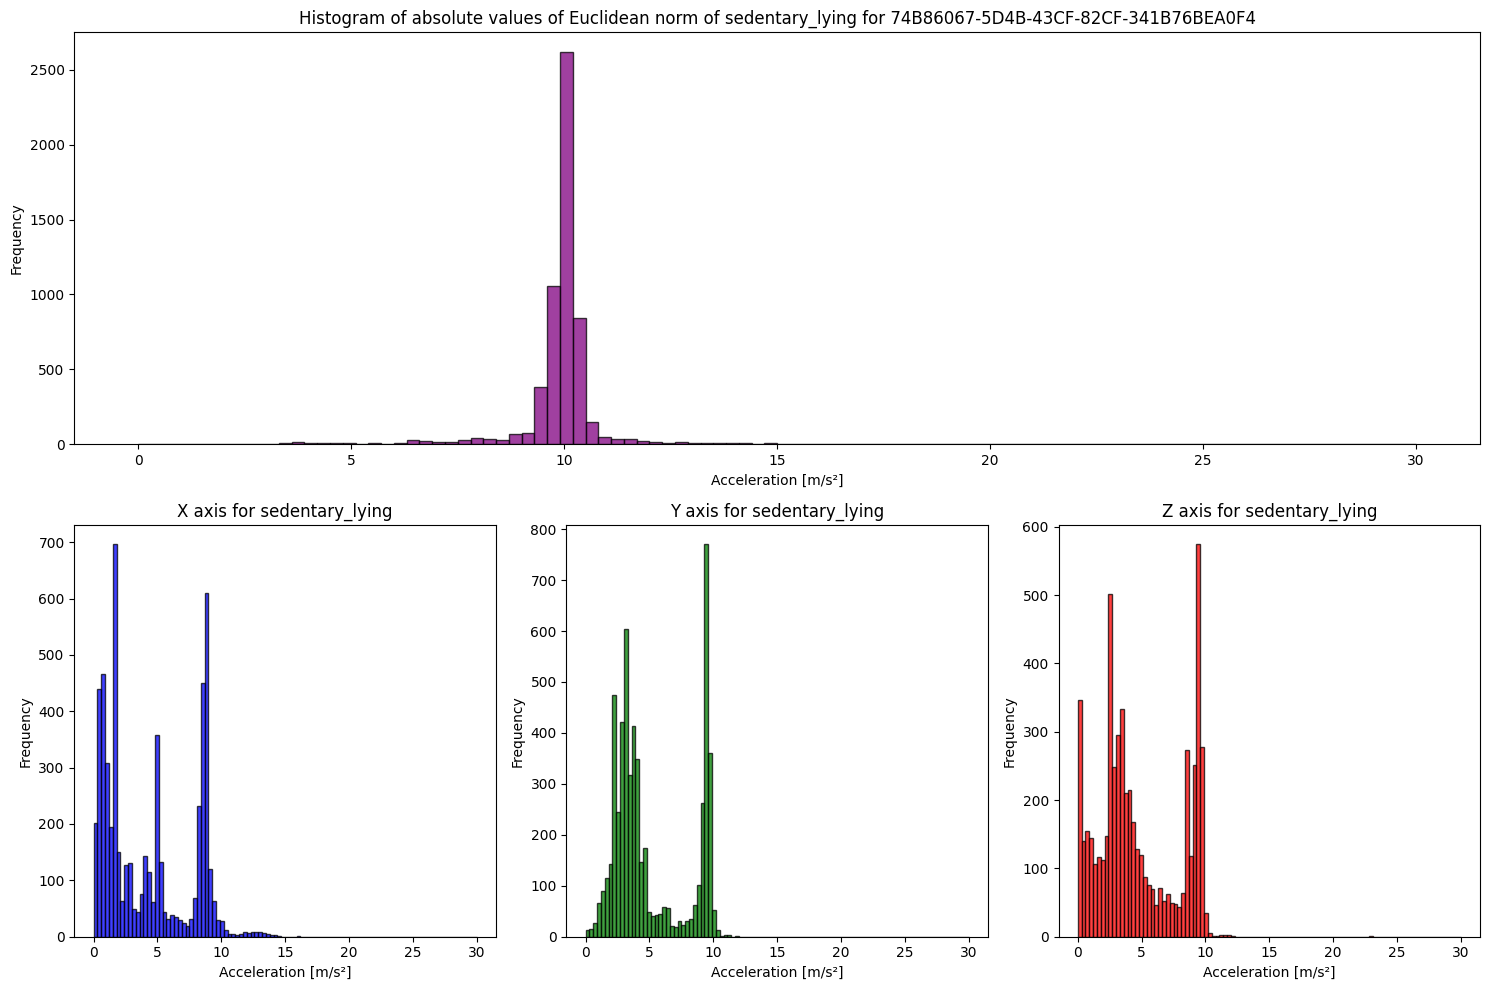

Label sedentary_sitting_other has 3679 samples
Valid size:(3679, 300, 3)
Shape of labeled data: (1103700, 3)
Mean Acceleration Magnitude: 9.98 m/s²


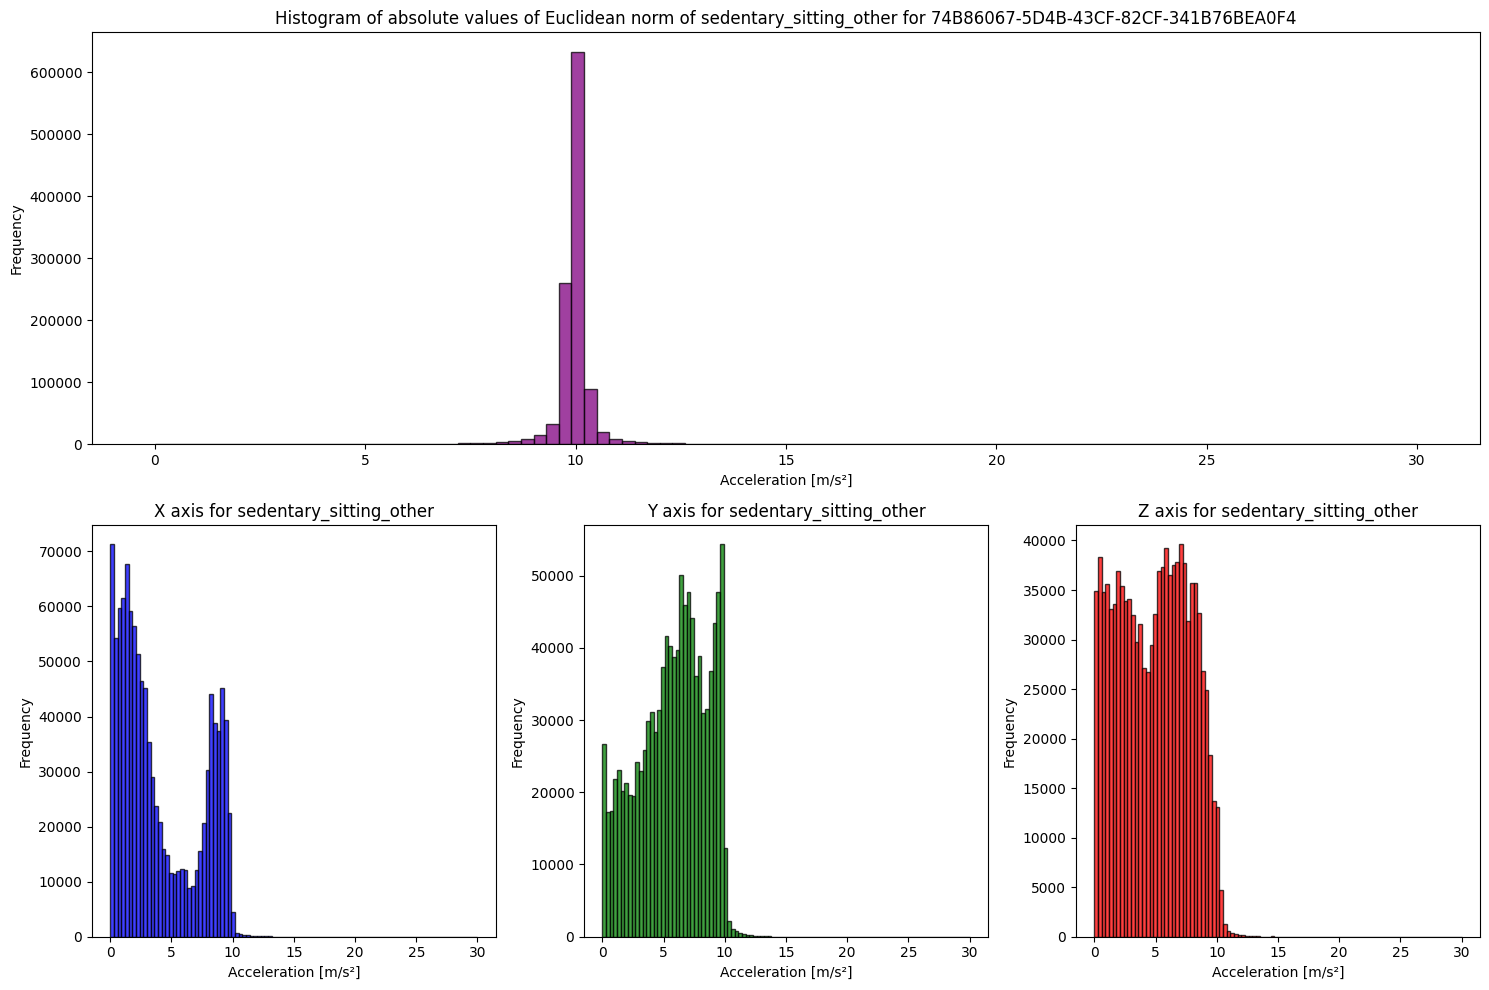

Label sedentary_sitting_transport has 128 samples
Valid size:(128, 300, 3)
Shape of labeled data: (38400, 3)
Mean Acceleration Magnitude: 10.06 m/s²


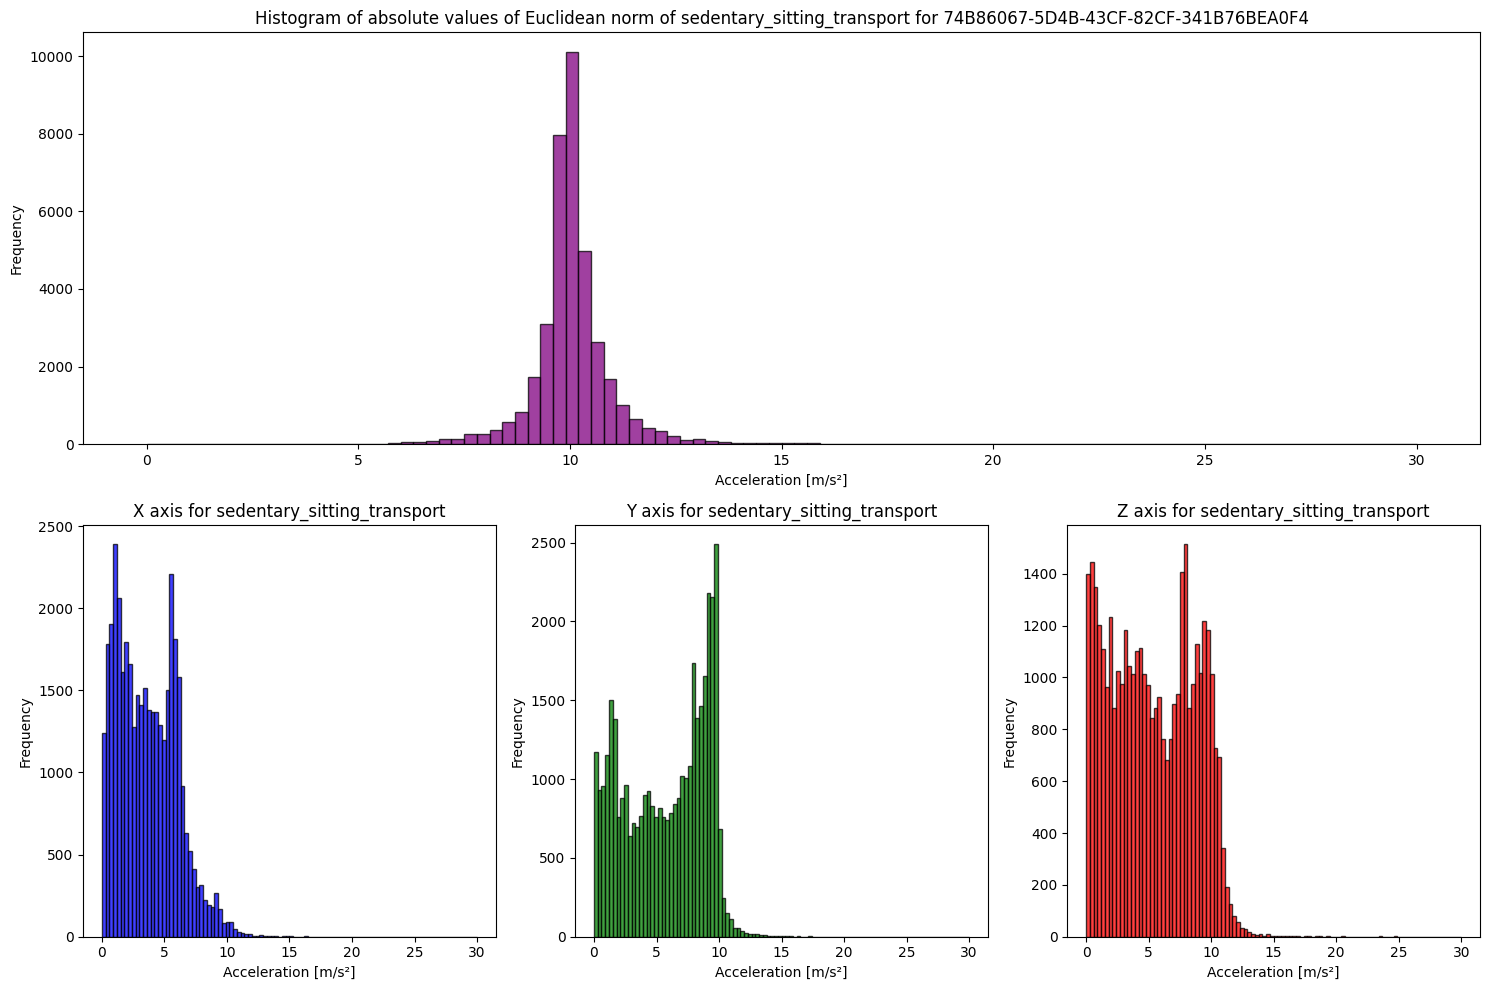

Label upright_standing has 186 samples
Valid size:(186, 300, 3)
Shape of labeled data: (55800, 3)
Mean Acceleration Magnitude: 9.99 m/s²


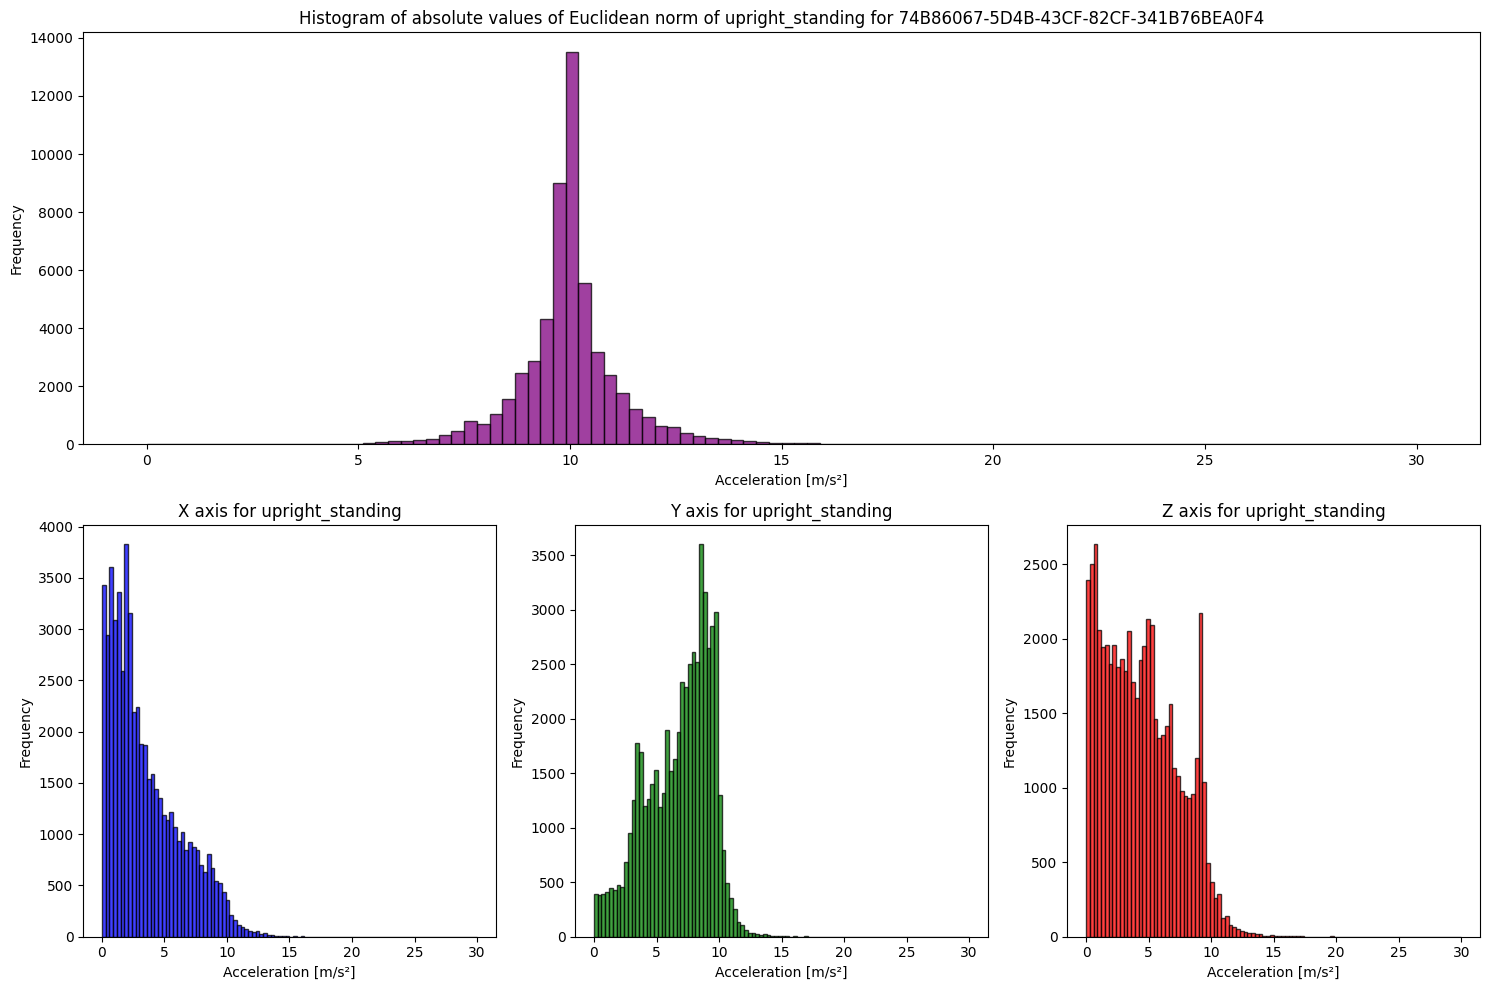

Label upright_stepping_low has 104 samples
Valid size:(104, 300, 3)
Shape of labeled data: (31200, 3)
Mean Acceleration Magnitude: 10.23 m/s²


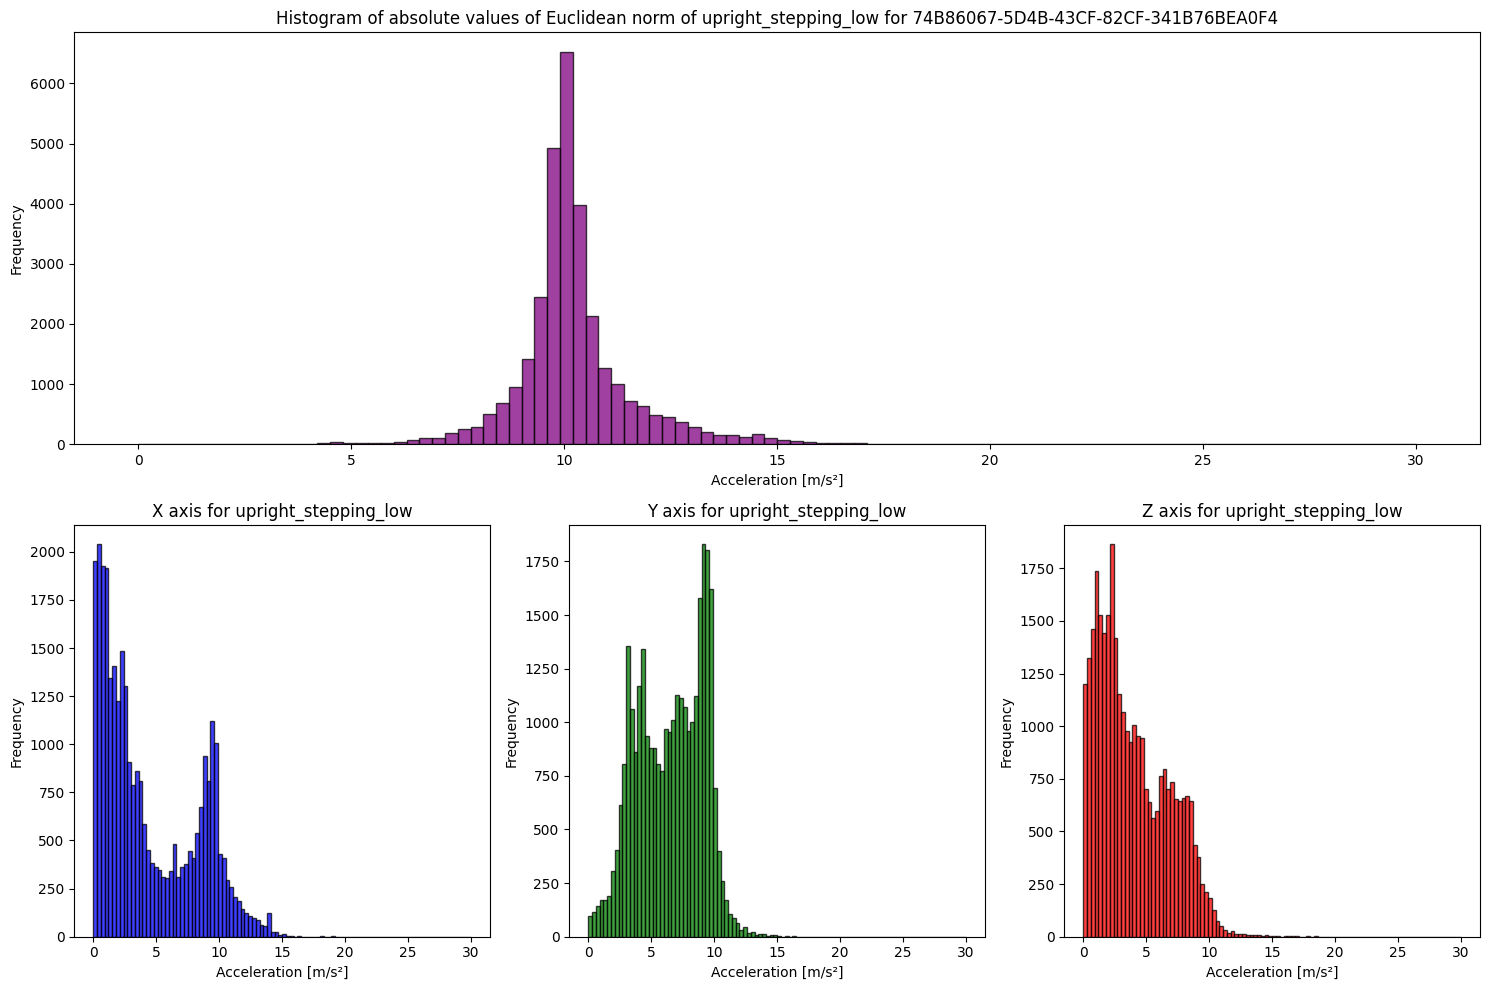

Label upright_stepping_moderate has 0 samples
Valid size:(0, 300, 3)
Shape of labeled data: (0, 3)
Mean Acceleration Magnitude: nan m/s²


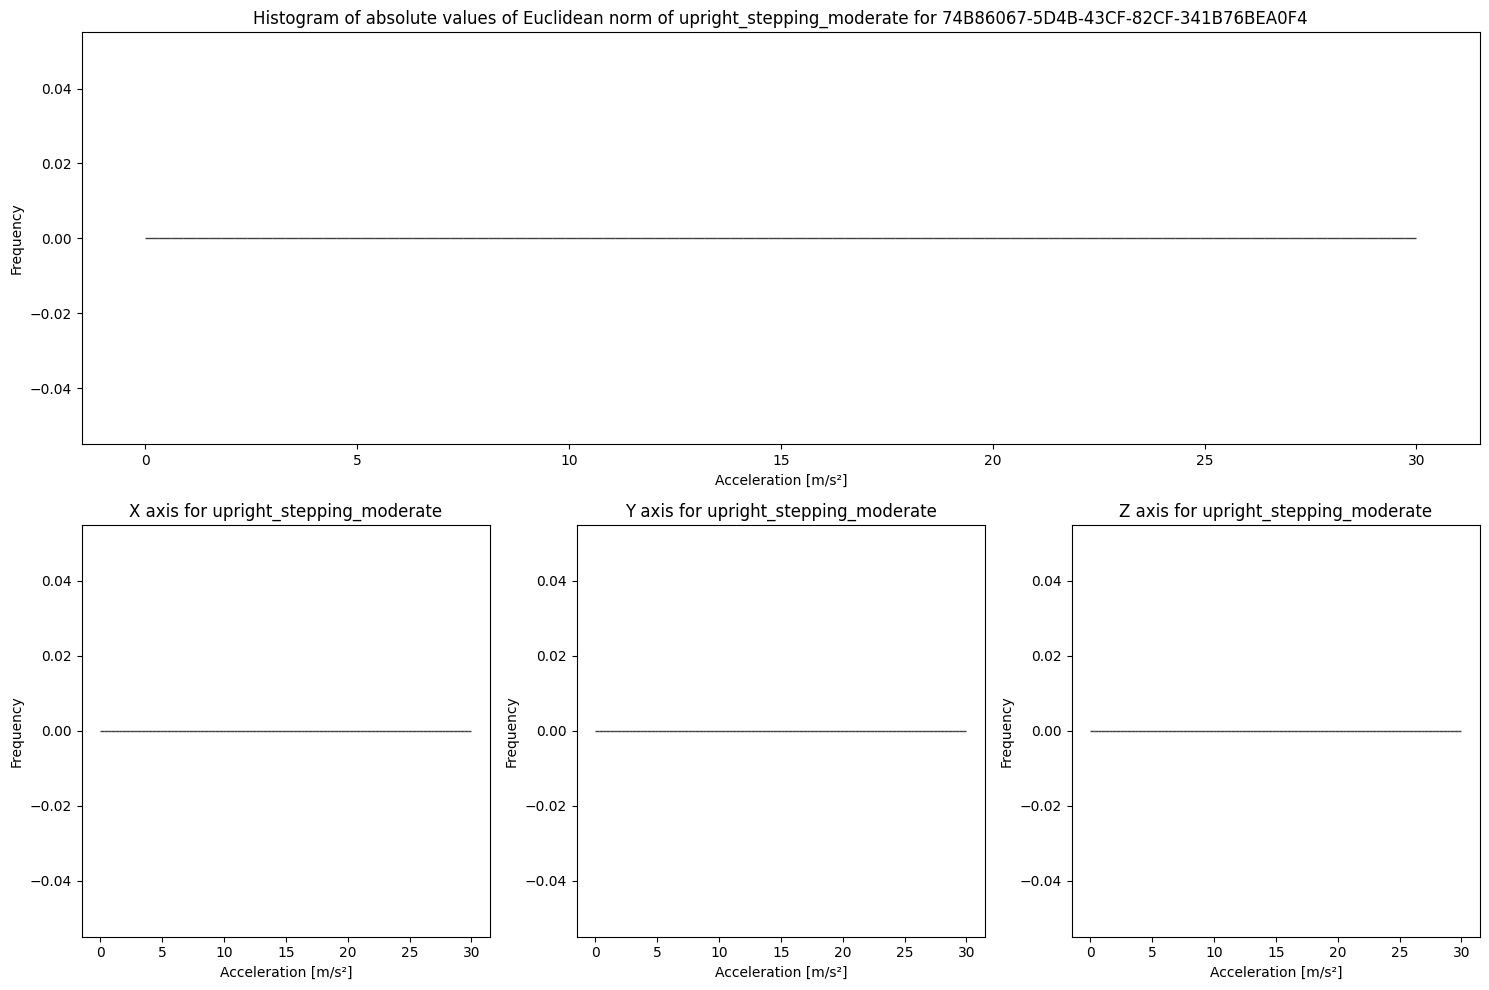

Label upright_stepping_vigorous has 0 samples
Valid size:(0, 300, 3)
Shape of labeled data: (0, 3)
Mean Acceleration Magnitude: nan m/s²


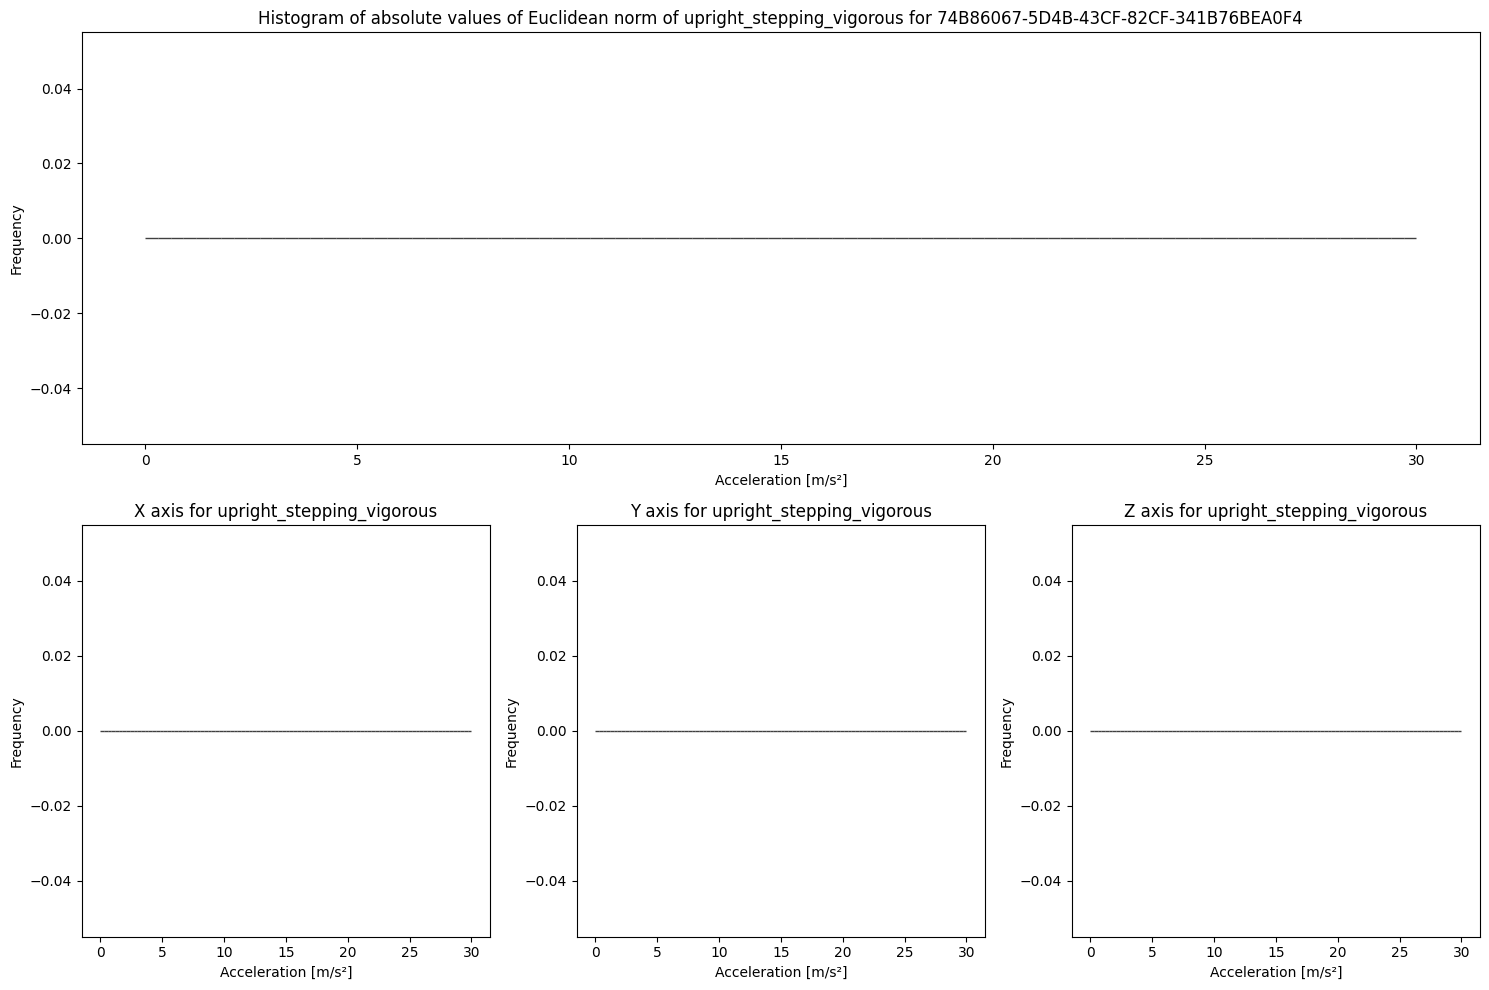

Label cycling has 1045 samples
Valid size:(1045, 300, 3)
Shape of labeled data: (313500, 3)
Mean Acceleration Magnitude: 11.47 m/s²


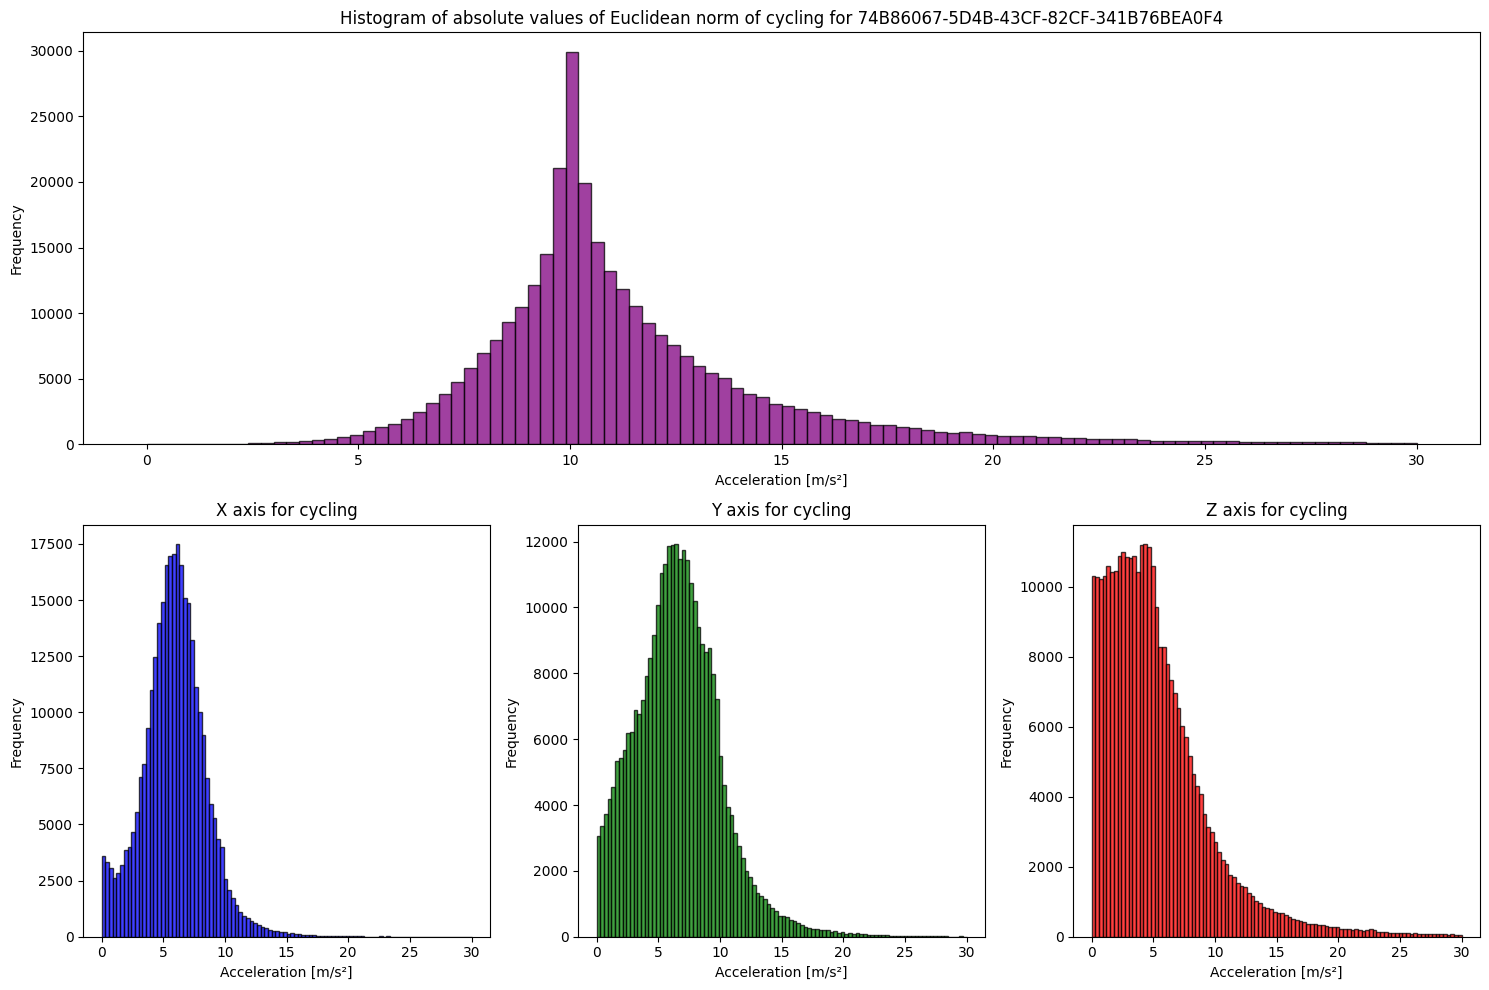

In [20]:
CHECK_DATA = True
if (CHECK_DATA):
    print("X_raw shape:", X_raw.shape)
    print("Y shape:", Y.shape)
    print("P shape:", P.shape)
    print("X min:", X_raw.min(),"X max:", X_raw.max())
    import matplotlib.pyplot as plt
    labels = list(label_mapping.keys())
    num_labels = Y.shape[1]
    print(f"{num_labels} labels: {labels}")
    colors = ['b', 'g', 'r']
    for label in range(num_labels):
        label_indices = np.where(Y[:, label] == 1)[0]
        print(f"Label {labels[label]} has {len(label_indices)} samples")
        label_data = X_raw[label_indices]
        # Find windows that contain any NaN
        valid_windows_mask = ~np.isnan(label_data).any(axis=(1, 2))  # Shape (N,)
        # Filter only valid windows
        accel_valid = label_data[valid_windows_mask]  # Shape (N_valid, 300, 3)
        # Compute norm and mean
        # accel_magnitude = np.linalg.norm(accel_valid, axis=2)
        # mean_magnitude_per_window = np.mean(accel_magnitude, axis=1)

        print(f"Valid size:{accel_valid.shape}")
        label_data = accel_valid.reshape(-1, 3)
        # Calculate the Euclidean norm of the 3 axes
        print(f"Shape of labeled data: {label_data.shape}")
        label_data = label_data * 9.81 / 1000 #convert from milli-g to m/s²

        euclidean_norm = np.linalg.norm(label_data, axis=1)
        # Compute the mean magnitude
        mean_magnitude = np.mean(euclidean_norm, axis=0)

        print(f"Mean Acceleration Magnitude: {mean_magnitude:.2f} m/s²")
        # Create a 2x3 grid for subplots
        plt.figure(figsize=(15, 10))
        # Plot the histogram of the Euclidean norm
        plt.subplot(2, 3, (1, 3))
        # Plot the histogram of the Euclidean norm
        plt.hist(euclidean_norm, bins=100, alpha=0.75,color='purple', edgecolor='black', range=(0, 30))
        plt.title(f'Histogram of absolute values of Euclidean norm of {labels[label]} for {Pid_tocheck}')
        plt.xlabel('Acceleration [m/s²]')
        plt.ylabel('Frequency')
        for i, axis in enumerate(['X', 'Y', 'Z']):
            plt.subplot(2, 3, i + 4)
            plt.hist(np.abs(label_data[:, i]), bins=100, alpha=0.75, color=colors[i], edgecolor='black', range=(0, 30))
            plt.title(f'{axis} axis for {labels[label]}')
            plt.xlabel('Acceleration [m/s²]')
            plt.ylabel('Frequency')
        plt.tight_layout()
        # Save the figure
        plot_dir = os.path.join("../plots/imgs/")
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"ExtraSensory Accel hist_{labels[label]}.png"))
        plt.show()
        plt.close()

In [21]:
# Compute the gravity magnitude (norm) for each window and sample
gravity_norm = np.linalg.norm(gravity, axis=2)  # Shape: (N, 300)

# Compute statistics
mean_gravity = np.mean(gravity_norm)  # Overall mean
std_gravity = np.std(gravity_norm)    # Standard deviation

# Print results
print(f"Mean Gravity: {mean_gravity:.3f} g")
print(f"Std Dev Gravity: {std_gravity:.3f} g")

# Check how many samples are within a reasonable range
within_range = np.sum((gravity_norm > 0.95) & (gravity_norm < 1.05)) / gravity_norm.size * 100
print(f"Percentage of samples in [95%, 105%] g: {within_range:.2f}%")

Mean Gravity: 1.000 g
Std Dev Gravity: 0.000 g
Percentage of samples in [95%, 105%] g: 100.00%


X shape: (6522, 300, 3)
Y shape: (6522, 8)
P shape: (6522,)
X min: -5.013651752082367 X max: 4.95919573737072
8 labels: ['sedentary_lying', 'sedentary_sitting_other', 'sedentary_sitting_transport', 'upright_standing', 'upright_stepping_low', 'upright_stepping_moderate', 'upright_stepping_vigorous', 'cycling']
Label sedentary_lying has 19 samples
Valid size:(19, 300, 3)
Shape of labeled data: (5700, 3)
Mean Acceleration Magnitude: 0.10 g


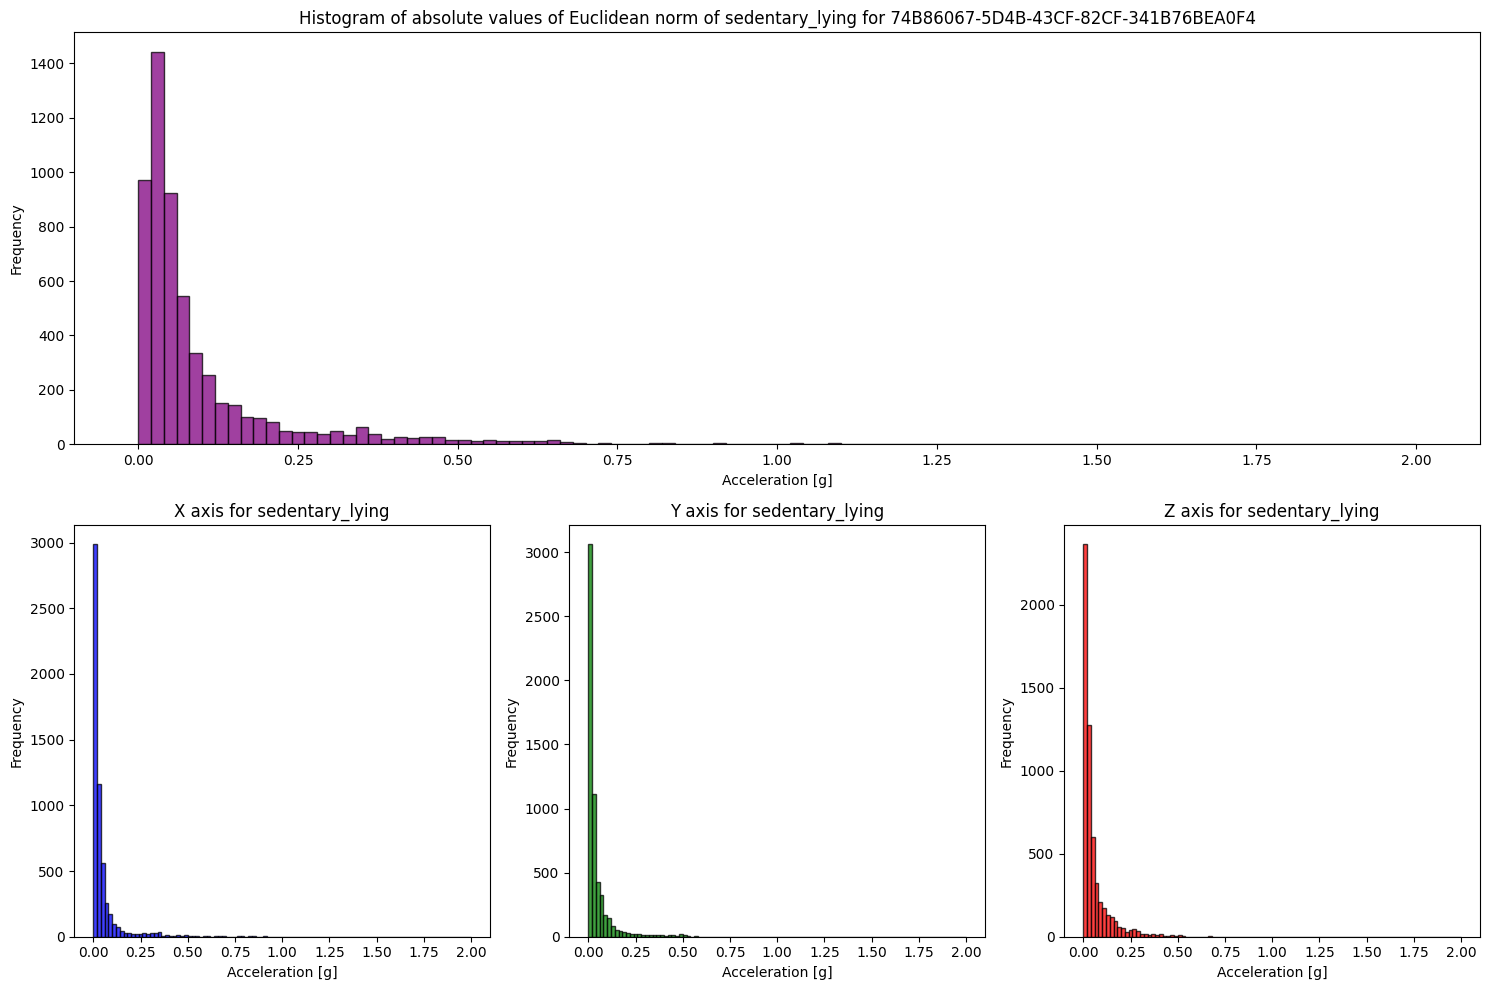

Label sedentary_sitting_other has 3679 samples
Valid size:(3679, 300, 3)
Shape of labeled data: (1103700, 3)
Mean Acceleration Magnitude: 0.08 g


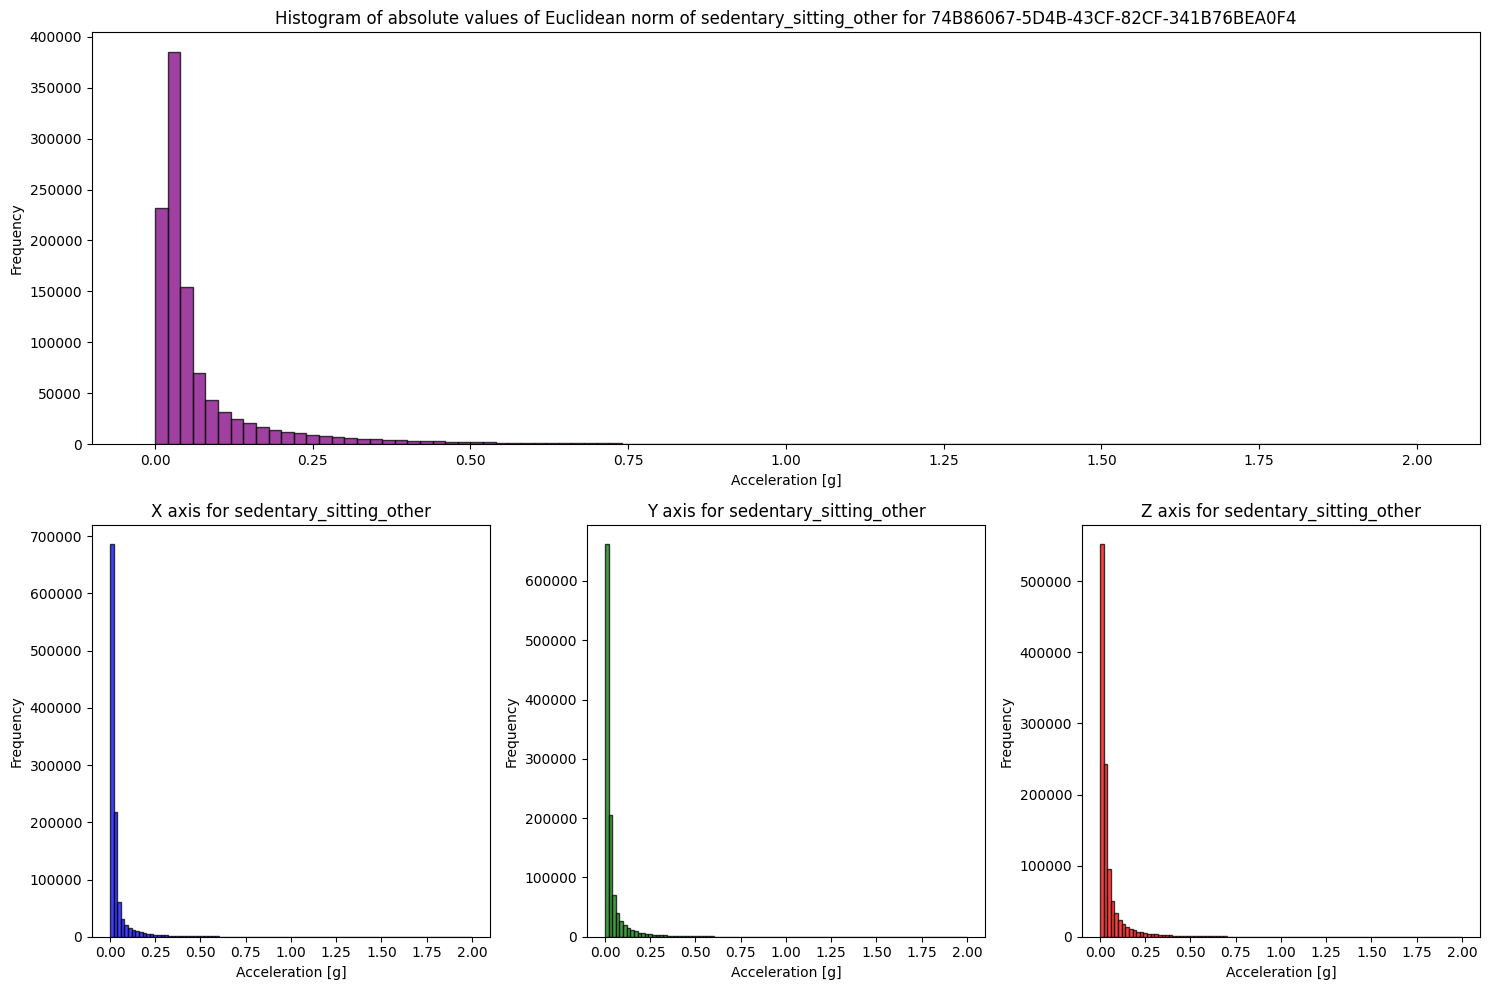

Label sedentary_sitting_transport has 128 samples
Valid size:(128, 300, 3)
Shape of labeled data: (38400, 3)
Mean Acceleration Magnitude: 0.17 g


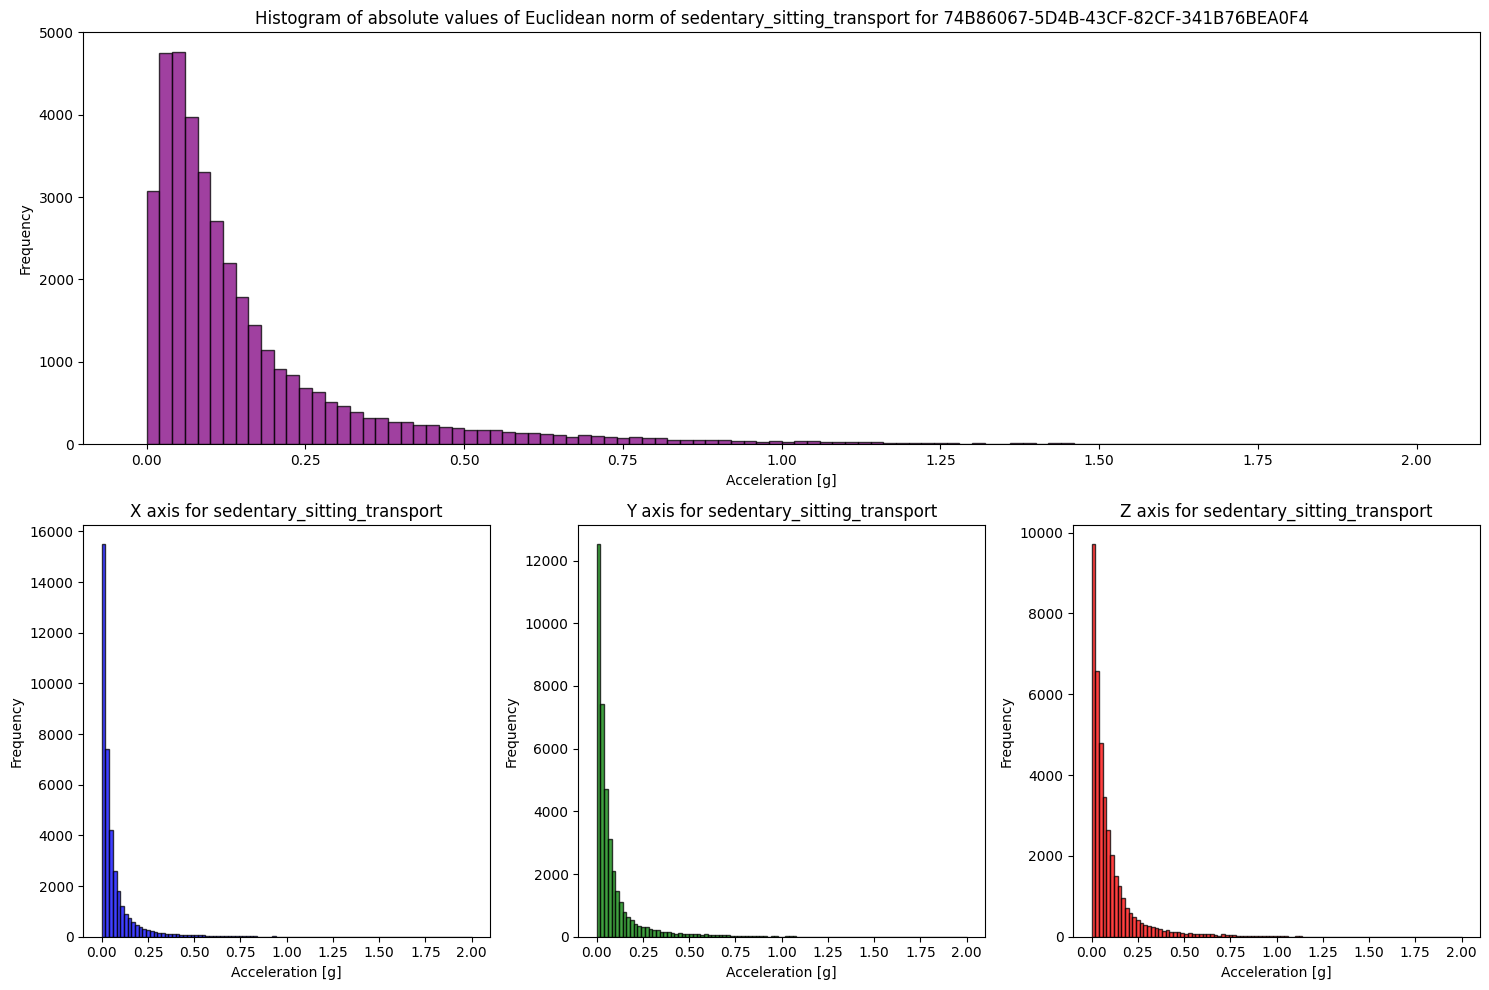

Label upright_standing has 186 samples
Valid size:(186, 300, 3)
Shape of labeled data: (55800, 3)
Mean Acceleration Magnitude: 0.23 g


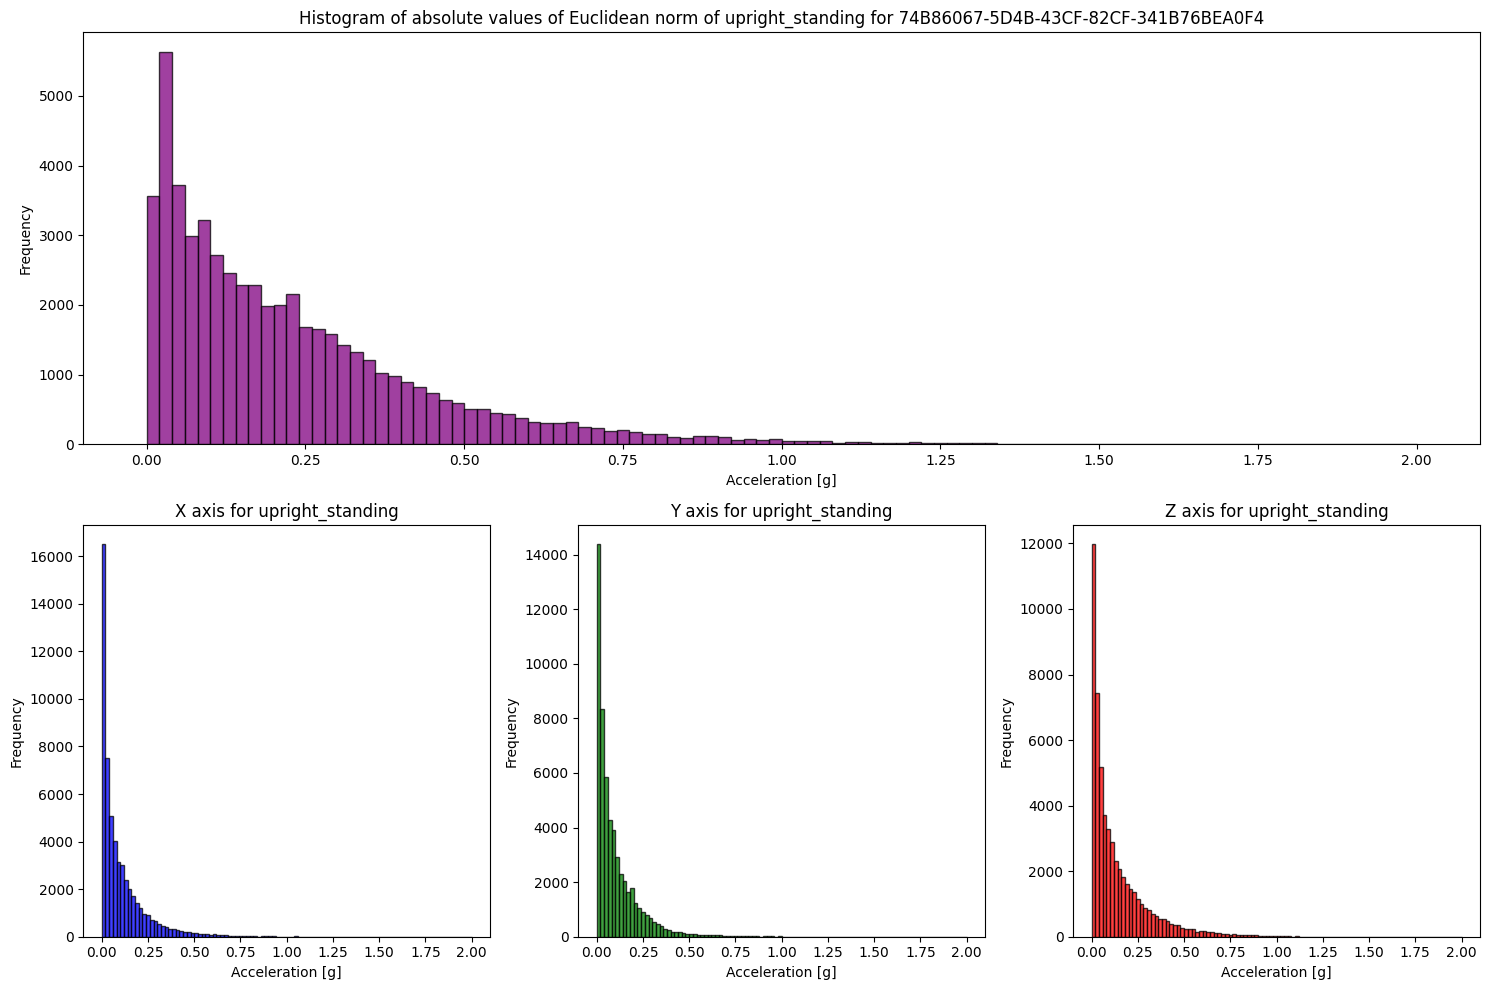

Label upright_stepping_low has 104 samples
Valid size:(104, 300, 3)
Shape of labeled data: (31200, 3)
Mean Acceleration Magnitude: 0.22 g


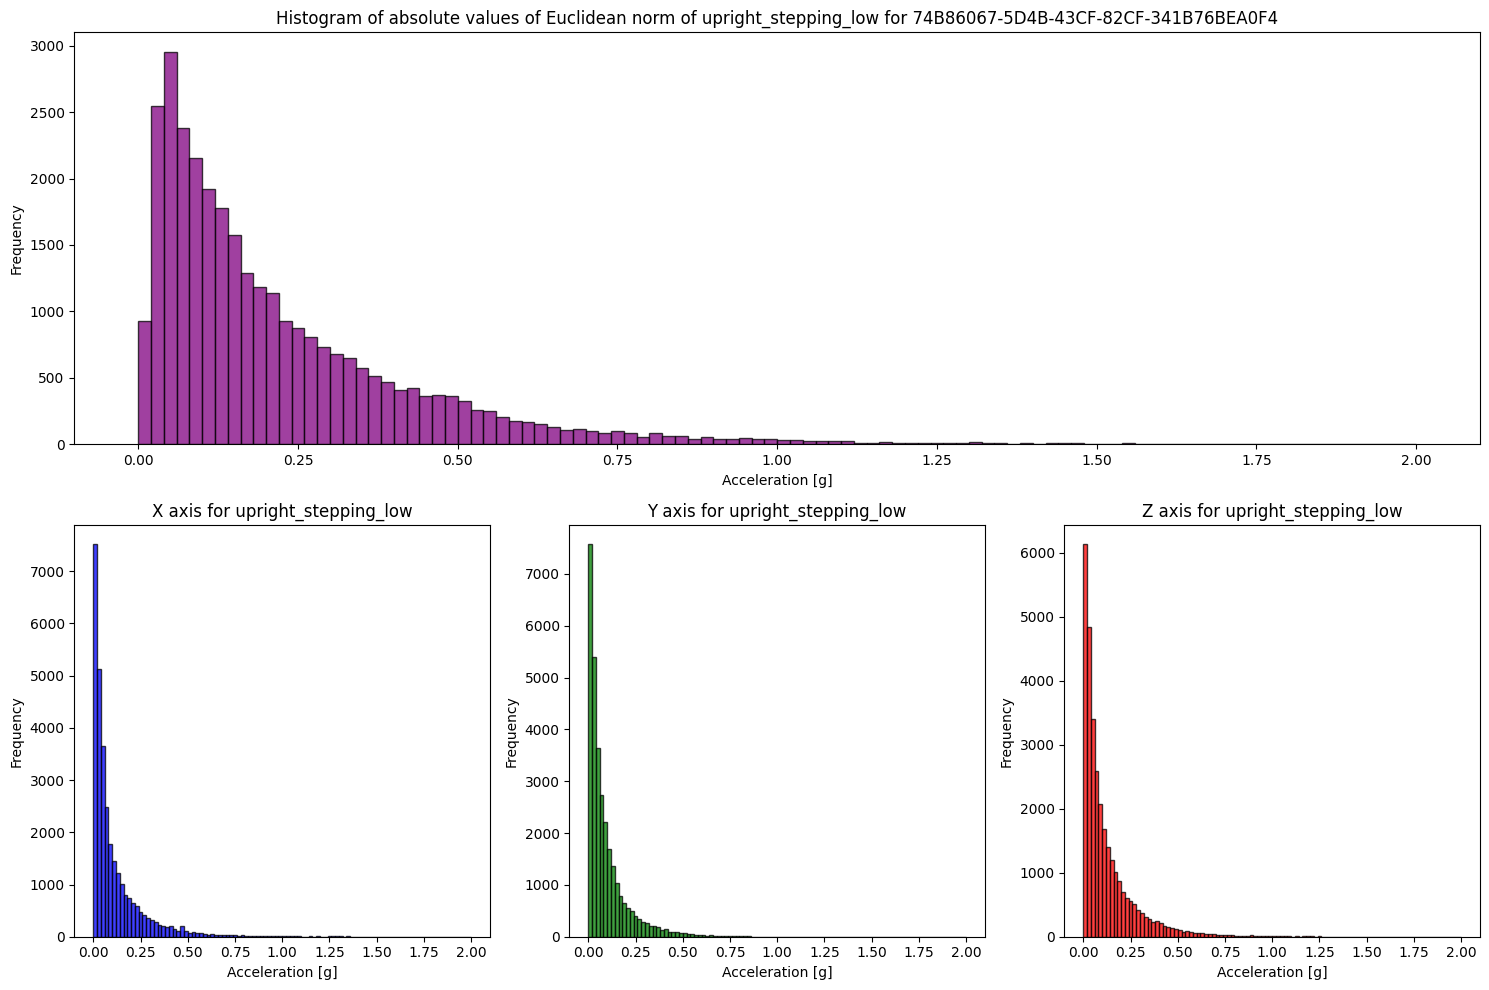

Label upright_stepping_moderate has 0 samples
Valid size:(0, 300, 3)
Shape of labeled data: (0, 3)
Mean Acceleration Magnitude: nan g


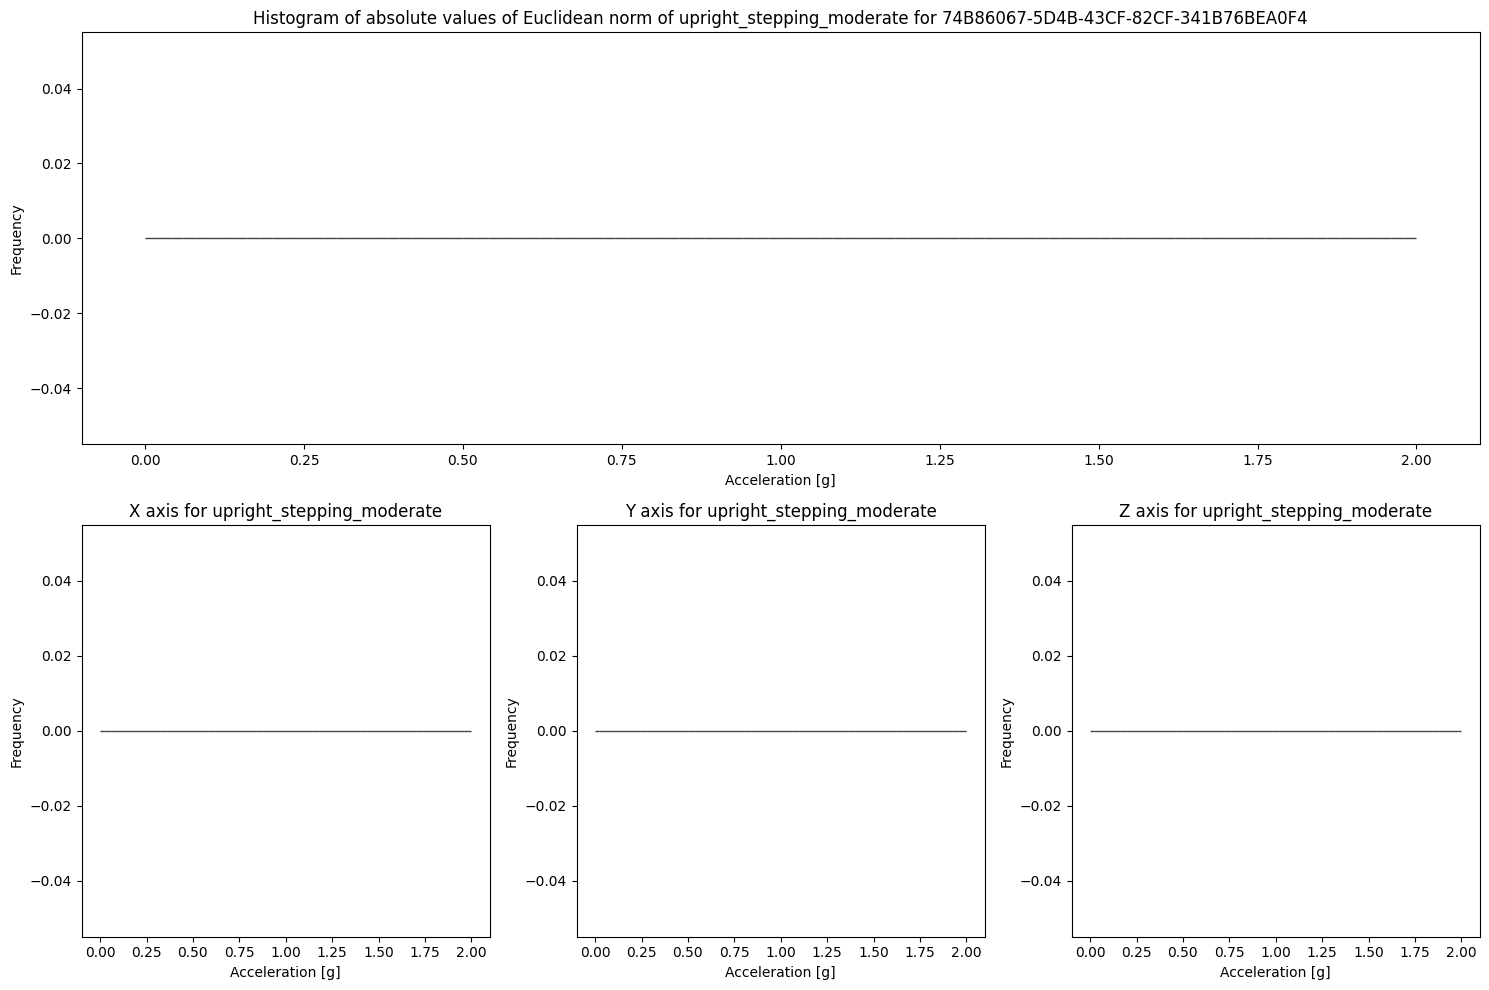

Label upright_stepping_vigorous has 0 samples
Valid size:(0, 300, 3)
Shape of labeled data: (0, 3)
Mean Acceleration Magnitude: nan g


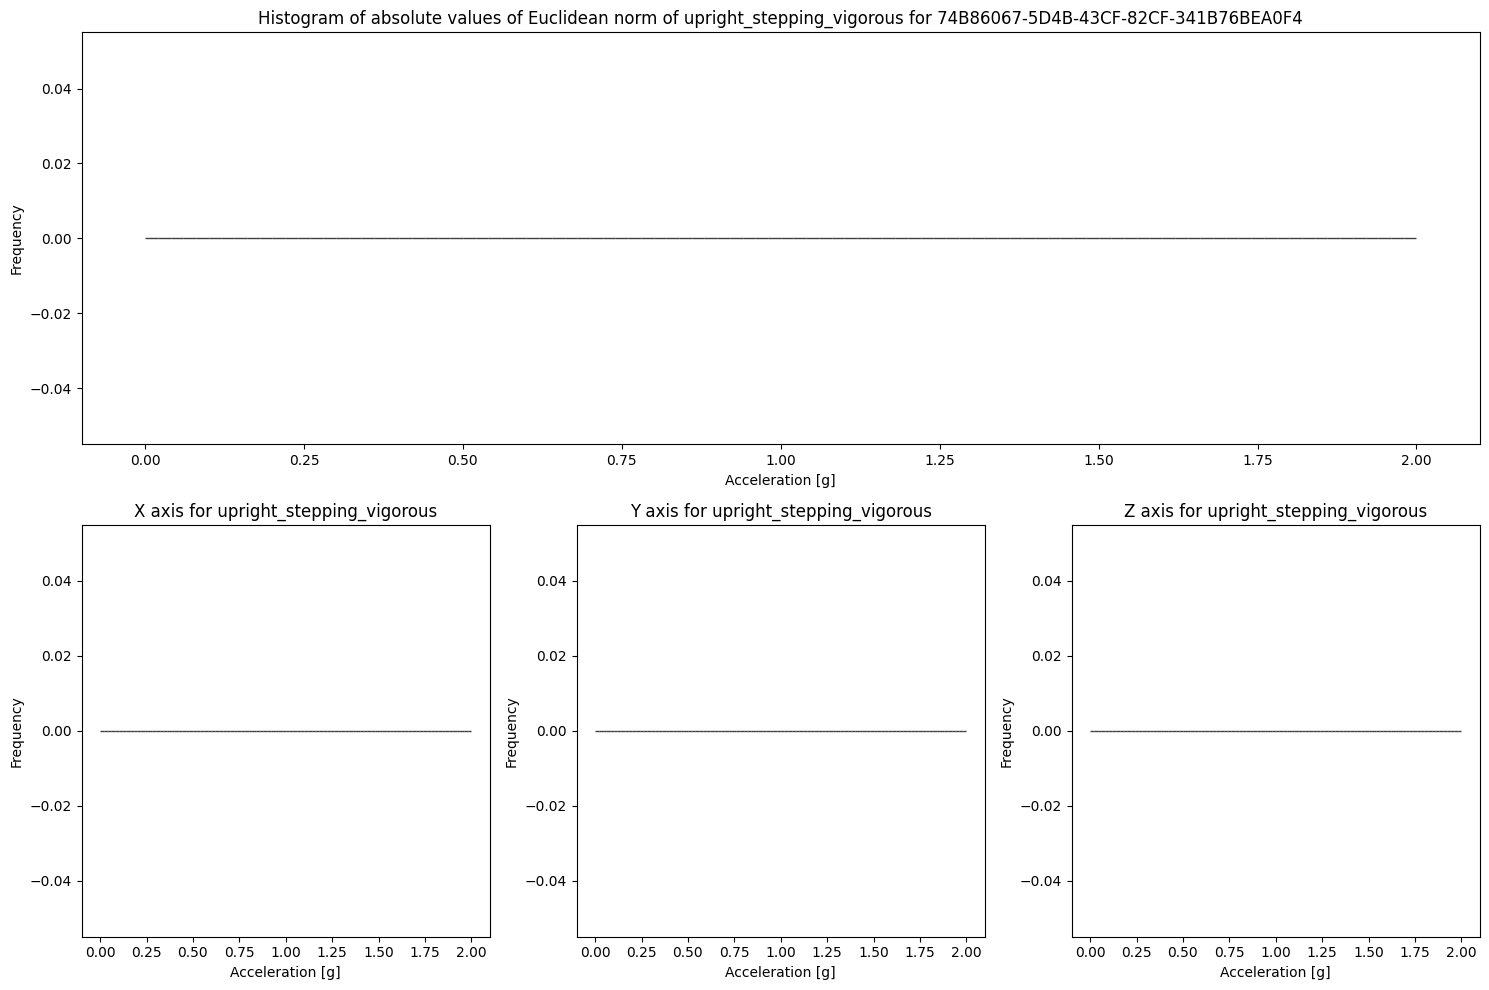

Label cycling has 1045 samples
Valid size:(1045, 300, 3)
Shape of labeled data: (313500, 3)
Mean Acceleration Magnitude: 0.51 g


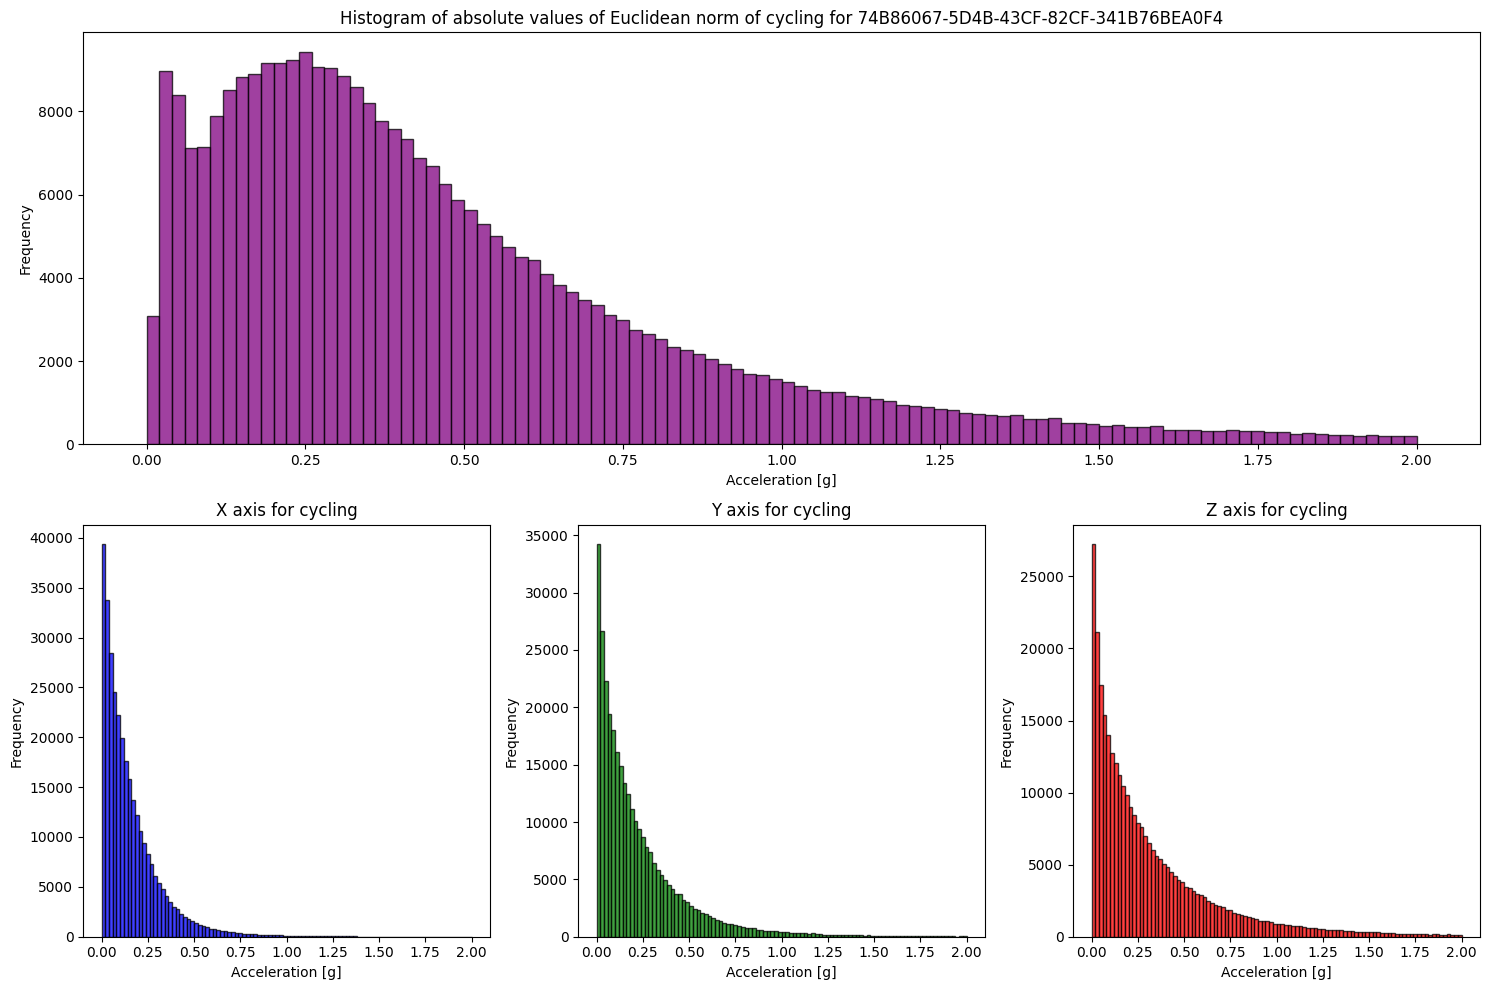

In [22]:
if (CHECK_DATA):
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)
    print("P shape:", P.shape)
    print("X min:", X.min(),"X max:", X.max())
    import matplotlib.pyplot as plt
    labels = list(label_mapping.keys())
    num_labels = Y.shape[1]
    print(f"{num_labels} labels: {labels}")
    colors = ['b', 'g', 'r']
    for label in range(num_labels):
        label_indices = np.where(Y[:, label] == 1)[0]
        print(f"Label {labels[label]} has {len(label_indices)} samples")
        label_data = X[label_indices]
        # Find windows that contain any NaN
        valid_windows_mask = ~np.isnan(label_data).any(axis=(1, 2))  # Shape (N,)
        # Filter only valid windows
        accel_valid = label_data[valid_windows_mask]  # Shape (N_valid, 300, 3)
        # Compute norm and mean
        # accel_magnitude = np.linalg.norm(accel_valid, axis=2)
        # mean_magnitude_per_window = np.mean(accel_magnitude, axis=1)

        print(f"Valid size:{accel_valid.shape}")
        label_data = accel_valid.reshape(-1, 3)
        # Calculate the Euclidean norm of the 3 axes
        print(f"Shape of labeled data: {label_data.shape}")
        # label_data = label_data * 9.81 / 1000 #convert from milli-g to m/s²

        euclidean_norm = np.linalg.norm(label_data, axis=1)
        # Compute the mean magnitude
        mean_magnitude = np.mean(euclidean_norm, axis=0)

        print(f"Mean Acceleration Magnitude: {mean_magnitude:.2f} g")
        # Create a 2x3 grid for subplots
        plt.figure(figsize=(15, 10))
        # Plot the histogram of the Euclidean norm
        plt.subplot(2, 3, (1, 3))
        # Plot the histogram of the Euclidean norm
        plt.hist(euclidean_norm, bins=100, alpha=0.75,color='purple', edgecolor='black', range=(0, 2))
        plt.title(f'Histogram of absolute values of Euclidean norm of {labels[label]} for {Pid_tocheck}')
        plt.xlabel('Acceleration [g]')
        plt.ylabel('Frequency')
        for i, axis in enumerate(['X', 'Y', 'Z']):
            plt.subplot(2, 3, i + 4)
            plt.hist(np.abs(label_data[:, i]), bins=100, alpha=0.75, color=colors[i], edgecolor='black', range=(0, 2))
            plt.title(f'{axis} axis for {labels[label]}')
            plt.xlabel('Acceleration [g]')
            plt.ylabel('Frequency')
        plt.tight_layout()
        # Save the figure
        plot_dir = os.path.join("../plots/imgs/")
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"ExtraSensory Lin Accel hist_{labels[label]}.png"))
        plt.show()
        plt.close()
        

## Combine Participants data into one

In [9]:
combined_X = []
combined_Y = []
combined_P = []
combined_T = []

for idx in range(len(ts_with_id)):
    file_path_X = processed_path + "/" + ts_with_id[idx] + "_X.npy"
    file_path_Y = processed_path + "/" + ts_with_id[idx] + "_Y.npy"
    file_path_P = processed_path + "/" + ts_with_id[idx] + "_P.npy"
    file_path_T = processed_path + "/" + ts_with_id[idx] + "_T.npy"
    if os.path.exists(file_path_X) and os.path.exists(file_path_Y) and os.path.exists(file_path_P) and os.path.exists(file_path_T):
        X = np.load(file_path_X)
        Y = np.load(file_path_Y)
        P = np.load(file_path_P, allow_pickle=True)
        T = np.load(file_path_T)
        combined_X.append(X)
        combined_Y.append(Y)
        combined_P.append(P)
        combined_T.append(T)
os.makedirs(combined_path, exist_ok=True)
combined_X = np.concatenate(combined_X, axis=0)
np.save(combined_path + "X_exp.npy", combined_X)
combined_Y = np.concatenate(combined_Y, axis=0)
np.save(combined_path + "Y_exp.npy", combined_Y)
combined_P = np.concatenate(combined_P, axis=0)
np.save(combined_path + "P_exp.npy", combined_P)
combined_T = np.concatenate(combined_T, axis=0)
np.save(combined_path + "T_exp.npy", combined_T)

logging.info(f"Combined data shape: {combined_X.shape}")
logging.info(f"Combined label shape: {combined_Y.shape}")
logging.info(f"Combined participant shape: {combined_P.shape}")
logging.info(f"Combined time shape: {combined_T.shape}")



2025-03-04 01:40:23,408 - INFO - Combined data shape: (323320, 300, 3)
2025-03-04 01:40:23,411 - INFO - Combined label shape: (323320, 8)
2025-03-04 01:40:23,412 - INFO - Combined participant shape: (323320,)
2025-03-04 01:40:23,413 - INFO - Combined time shape: (323320,)


### Check the labels
Check if there is any simultanuous labels

In [10]:
# Sum each row of combined_Y
row_sums = np.sum(combined_Y, axis=1)

# Count the number of rows that sum to each value from 0 to 8
counts = np.bincount(row_sums, minlength=9)

# Print the counts
for i in range(9):
    print(f"Number of rows that sum to {i}: {counts[i]}")

Number of rows that sum to 0: 89830
Number of rows that sum to 1: 219727
Number of rows that sum to 2: 13744
Number of rows that sum to 3: 19
Number of rows that sum to 4: 0
Number of rows that sum to 5: 0
Number of rows that sum to 6: 0
Number of rows that sum to 7: 0
Number of rows that sum to 8: 0


In [11]:
import pandas as pd
import openpyxl

# Find the mask for multi labels
mask_2_labels = np.sum(combined_Y, axis=1) == 2
mask_3_labels = np.sum(combined_Y, axis=1) == 3
label_array_2 = np.argwhere(combined_Y[mask_2_labels] == 1)[:,1].reshape(-1, 2)
label_array_3 = np.argwhere(combined_Y[mask_3_labels] == 1)[:,1].reshape(-1, 3)
# Create dataframes for 2 labels and 3 labels
df_2_labels = pd.DataFrame({
    'participant_id': combined_P[mask_2_labels],
    'time': combined_T[mask_2_labels],
    'label_1': label_array_2[:,0],
    'label_2': label_array_2[:,1]
})

df_3_labels = pd.DataFrame({
    'participant_id': combined_P[mask_3_labels],
    'time': combined_T[mask_3_labels],
    'label_1': label_array_3[:,0],
    'label_2': label_array_3[:,1],
    'label_3': label_array_3[:,2]
})

# Map label indices to label names
label_names = list(label_mapping.keys())
df_2_labels['label_1'] = df_2_labels['label_1'].map(lambda x: label_names[x])
df_2_labels['label_2'] = df_2_labels['label_2'].map(lambda x: label_names[x])

df_3_labels['label_1'] = df_3_labels['label_1'].map(lambda x: label_names[x])
df_3_labels['label_2'] = df_3_labels['label_2'].map(lambda x: label_names[x])
df_3_labels['label_3'] = df_3_labels['label_3'].map(lambda x: label_names[x])

# Create an Excel writer object
excel_path = 'multi_labels_report.xlsx'
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    df_2_labels.to_excel(writer, sheet_name='2_labels', index=False)
    df_3_labels.to_excel(writer, sheet_name='3_labels', index=False)

print(f"Excel file saved to {excel_path}")
# remove combined_X to save memory
# del combined_X
# del combined_P
# del combined_T

Excel file saved to multi_labels_report.xlsx


In [19]:
mask_1_labels = np.sum(combined_Y, axis=1) == 1
label_array_1 = np.argwhere(combined_Y[mask_1_labels] == 1)[:,1].reshape(-1, 1)
df_1_labels = pd.DataFrame({
    'participant_id': combined_P[mask_1_labels],
    'time': combined_T[mask_1_labels],
    'label': label_array_1[:,0]
})
df_1_labels['label'] = df_1_labels['label'].map(lambda x: label_names[x])
# print a pivot table of the number of samples for each label
pivot_table = df_1_labels.pivot_table(index='label', aggfunc='size')
# print(pivot_table)
logging.info(f"Number of samples for each label: \n{pivot_table}")
# print a pivot table of the number of samples for each participant
pivot_table = df_1_labels.pivot_table(index='participant_id', aggfunc='size')
# print(pivot_table)
logging.info(f"Number of samples for each participant: \n{pivot_table}")
#filter out participants with less than 100 samples
mask = pivot_table > 100
filtered_participants = pivot_table[mask].index
# print(filtered_participants)
logging.info(f"Participants with more than 100 samples: {filtered_participants}")
# filter out participants with less than 100 samples
df_1_labels_filtered = df_1_labels[df_1_labels['participant_id'].isin(filtered_participants)]
# print a pivot table of the number of samples for each label
pivot_table = df_1_labels_filtered.pivot_table(index='label', aggfunc='size')
# print(pivot_table)
logging.info(f"Number of samples for each label after filtering: \n{pivot_table}")
# print a pivot table of the number of samples for each participant
pivot_table = df_1_labels_filtered.pivot_table(index='participant_id', aggfunc='size')
# print(pivot_table)
logging.info(f"Number of samples for each participant after filtering: \n{pivot_table}")
# filter out participants with less than 100 samples from combined_X, combined_Y, combined_P, combined_T
mask = np.isin(combined_P, filtered_participants)
combined_X_filtered = combined_X[mask & mask_1_labels]
combined_Y_filtered = combined_Y[mask & mask_1_labels]
combined_P_filtered = combined_P[mask & mask_1_labels]
combined_T_filtered = combined_T[mask & mask_1_labels]

#convert df_1_labels_filtered['label'] to numpy array
label_array_1_filtered = df_1_labels_filtered['label'].to_numpy()

# save filtered data
np.save(combined_path + "X_filtered.npy", combined_X_filtered)
np.save(combined_path + "Y_filtered.npy", label_array_1_filtered)
np.save(combined_path + "P_filtered.npy", combined_P_filtered)
np.save(combined_path + "T_filtered.npy", combined_T_filtered)
logging.info(f"Filtered data saved to {combined_path}")
logging.info(f"Filtered data shape: X:{combined_X_filtered.shape}, Y:{label_array_1_filtered.shape}, P:{combined_P_filtered.shape}, T:{combined_T_filtered.shape}")
# print head of filtered label data
print(df_1_labels_filtered.head())
#save the filtered label data
df_1_labels_filtered.to_csv(combined_path + "filtered_labels.csv", index=False)
logging.info(f"Filtered label data saved to {combined_path}filtered_labels.csv")


2025-03-04 01:59:54,480 - INFO - Number of samples for each label: 
label
cycling                          5203
sedentary_lying                 86086
sedentary_sitting_other        122237
sedentary_sitting_transport       186
upright_standing                 4294
upright_stepping_low             1721
dtype: int64
2025-03-04 01:59:54,505 - INFO - Number of samples for each participant: 
participant_id
00EABED2-271D-49D8-B599-1D4A09240601      402
098A72A5-E3E5-4F54-A152-BBDA0DF7B694     1688
0A986513-7828-4D53-AA1F-E02D6DF9561B     2757
0BFC35E2-4817-4865-BFA7-764742302A2D     1088
0E6184E1-90C0-48EE-B25A-F1ECB7B9714E     4636
1155FF54-63D3-4AB2-9863-8385D0BD0A13     1757
11B5EC4D-4133-4289-B475-4E737182A406     5942
136562B6-95B2-483D-88DC-065F28409FD2     8412
1538C99F-BA1E-4EFB-A949-6C7C47701B20       58
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842     4286
24E40C4C-A349-4F9F-93AB-01D00FB994AF     1712
27E04243-B138-4F40-A164-F40B60165CF3     1241
2C32C23E-E30C-498A-8DD2-0EFB9150A02E     959

                         participant_id        time                    label
0  0BFC35E2-4817-4865-BFA7-764742302A2D  1445621325  sedentary_sitting_other
1  0BFC35E2-4817-4865-BFA7-764742302A2D  1445623527  sedentary_sitting_other
2  0BFC35E2-4817-4865-BFA7-764742302A2D  1445467206  sedentary_sitting_other
3  0BFC35E2-4817-4865-BFA7-764742302A2D  1445379883  sedentary_sitting_other
4  0BFC35E2-4817-4865-BFA7-764742302A2D  1445575382  sedentary_sitting_other


2025-03-04 01:59:57,183 - INFO - Filtered label data saved to /data/ssl_wearable/data/downstream/ExtraSensory_30Hz_10s/filtered_labels.csv


In [18]:
ts_files = os.listdir(processed_path)
df = pd.read_csv(processed_path + "/" + ts_files[0])
print(df.head())
print(df.columns)
print(df.shape)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte

In [23]:
df["time_shift"] = df["time"] - df["time"].shift(1)
df["time_shift"].head()
most_occurrence = df["time_shift"].mode()[0]
mid_value = df["time_shift"].median()

print("Most Occurrence:", most_occurrence)
print("Mid Value:", mid_value)
print ("frequency:", 1 / mid_value, "Hz")

NameError: name 'df' is not defined